In [69]:
import math   
import matplotlib.pyplot as plt   
from matplotlib.pyplot import figure
import pandas as pd
import numpy as np   
import mne 
import heartpy as hp
import os
from functions.make_plots import *

# Load ECG data

In [2]:
def bdf_loader(folder, seconds, chan1="EXG2-0", chan2="EXG2"):
    """
    Load ECG signals from BDF files in the specified folder.

    Parameters:
    - folder (str): Path to the folder containing BDF files.
    - seconds (int): Duration of the signal to extract in seconds.
    - chan1 (str): Primary channel name to extract.
    - chan2 (str): Secondary channel name to extract if chan1 is not found.

    Returns:
    - ecg_signals_dict (dict): Dictionary containing ECG signals for each subject.
    """
    
    ecg_signals_dict = {}
    
    for i in range(13):
        path = os.path.join(folder, f"sj{i+1}.bdf")
        
        temp = mne.io.read_raw_bdf(path, verbose='ERROR')

        # Get the index of the channel
        available_channels = temp.ch_names
        selected_channel = chan1 if chan1 in available_channels else chan2
        
        # Get the index of start and end of the signal
        temp_events = mne.find_events(temp, verbose='ERROR')  
        temp_start = temp_events[0, 0]
        temp_end = temp_start + int(temp.info['sfreq'] * seconds) 

        # Get the signal
        signal = temp.get_data(picks=selected_channel)[:, temp_start:temp_end]
        # Append to the dictionary
        ecg_signals_dict[i+1] = signal[0]
    
    return ecg_signals_dict


In [3]:
folder = "../Data/ECG_Signals"
ECG_data_dict = bdf_loader(folder, 120)

# Plot the ECG data

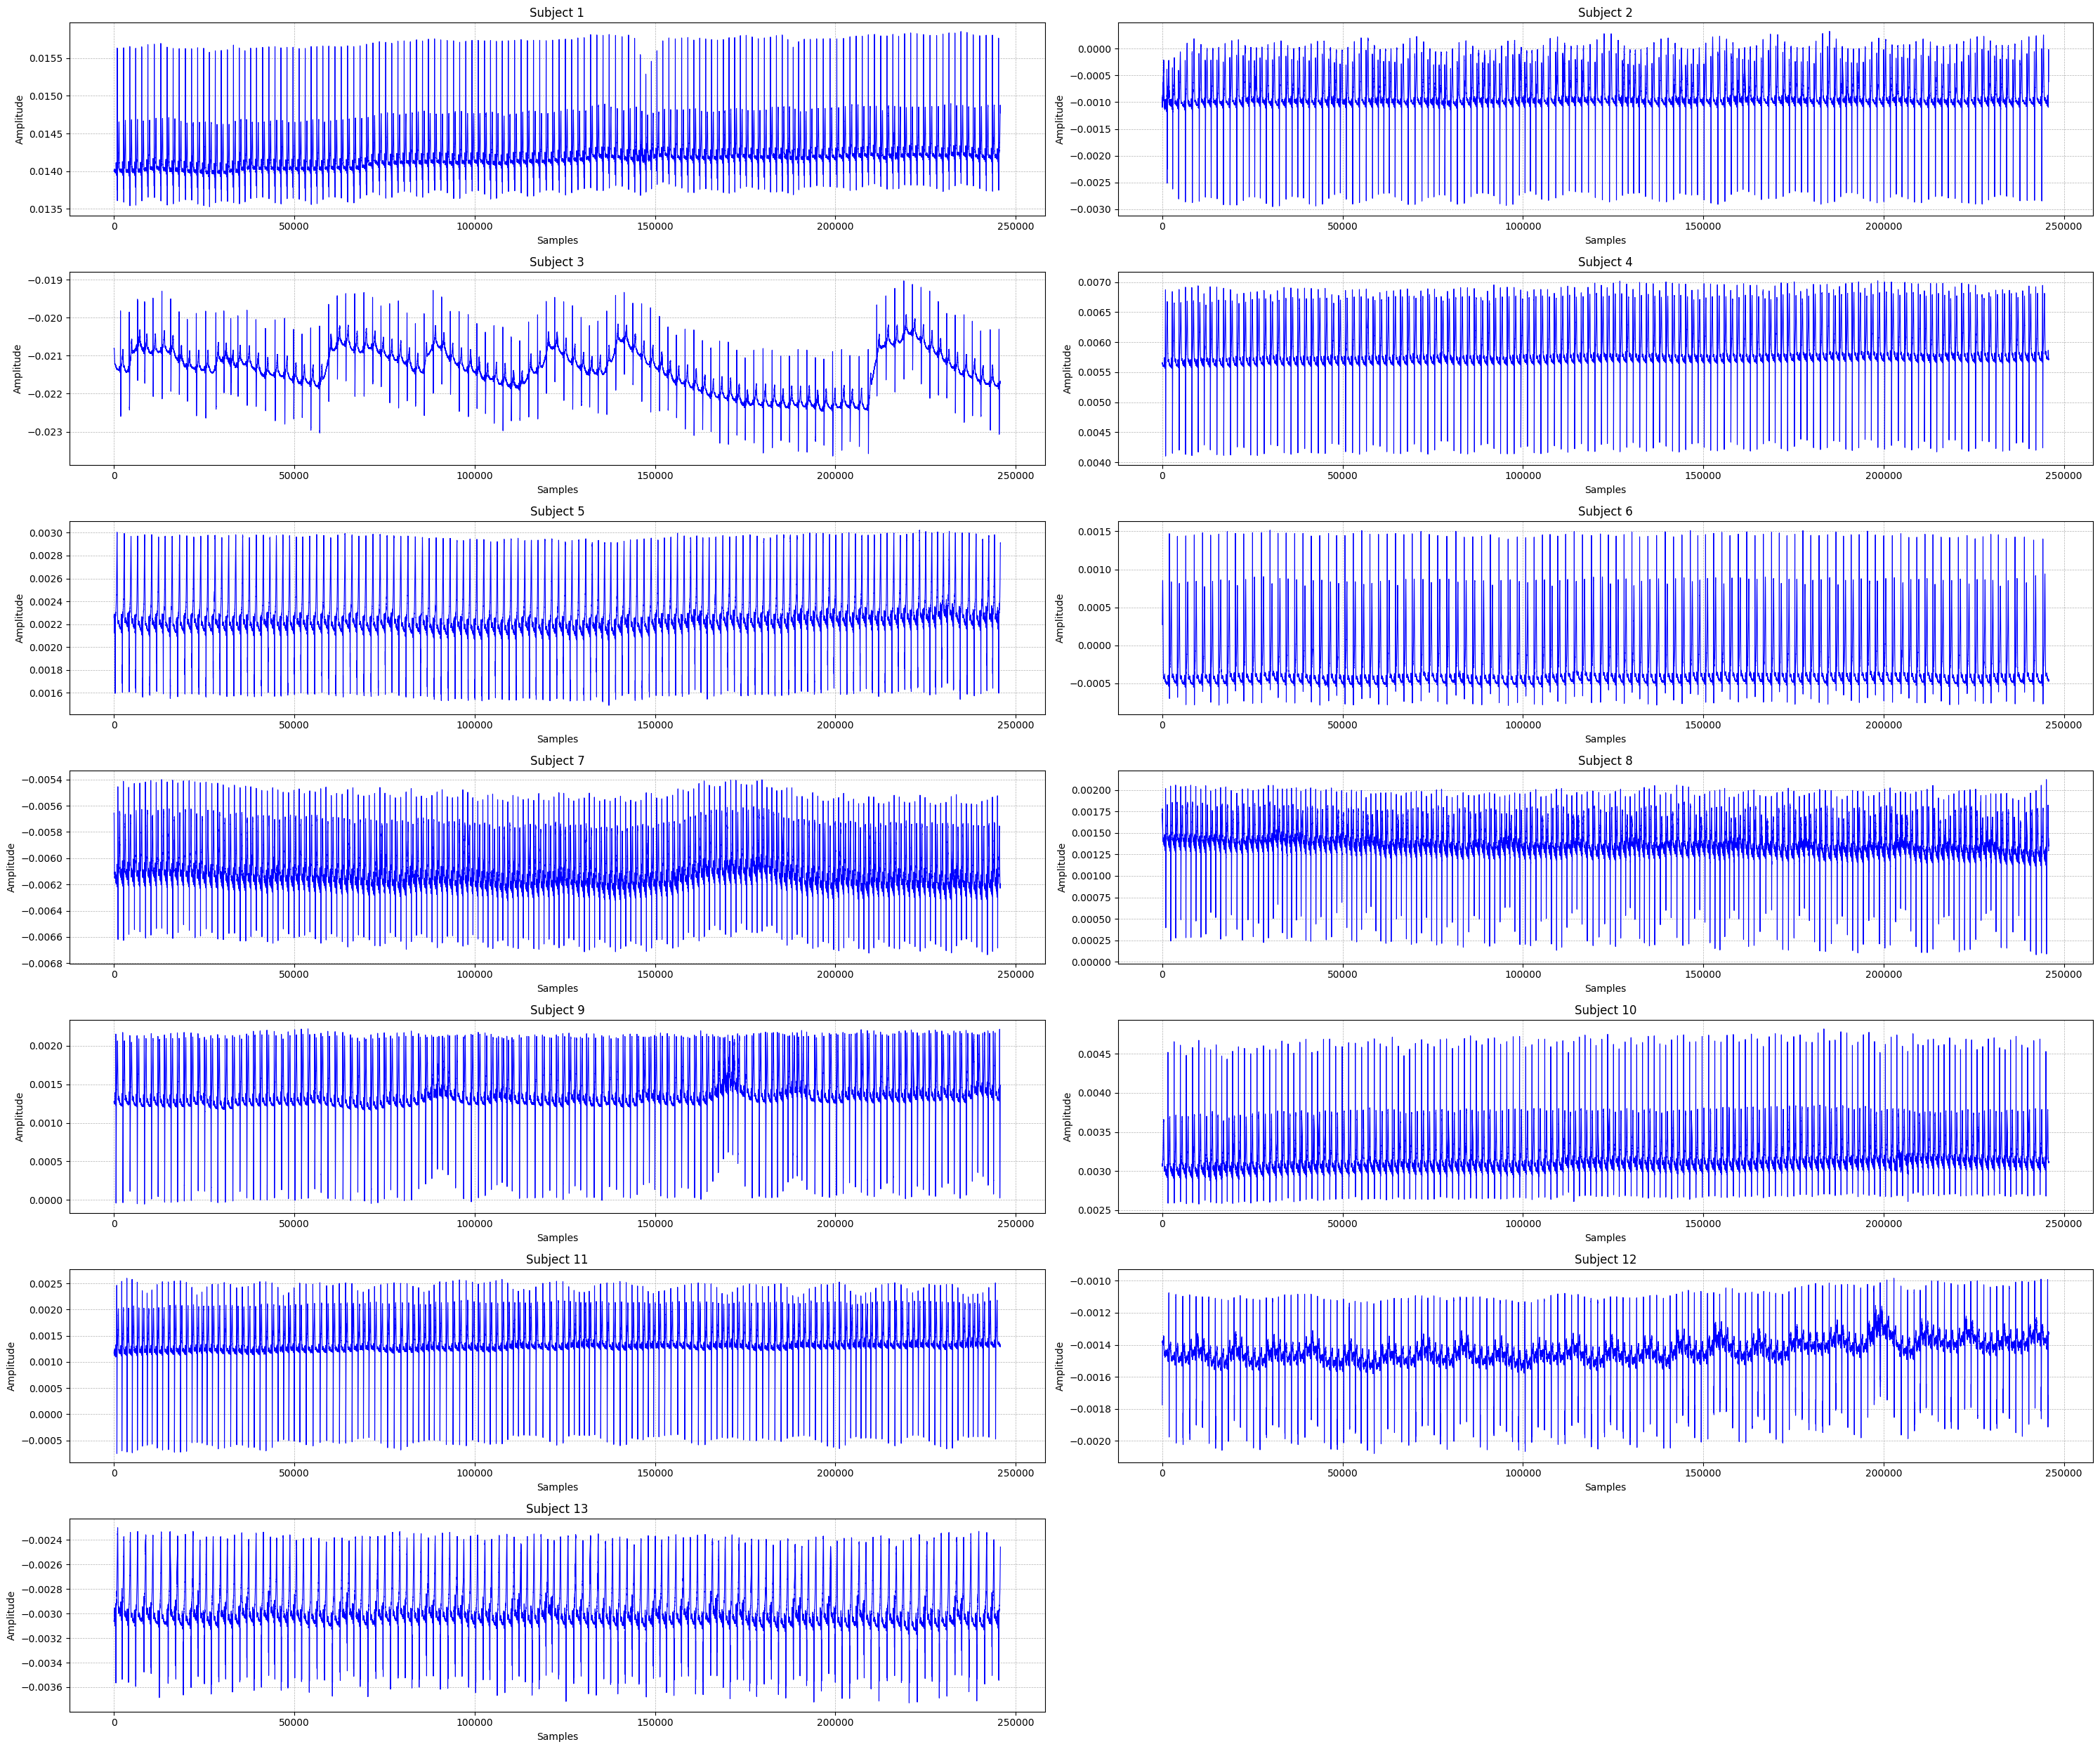

In [4]:
n_subjects = len(ECG_data_dict)
cols = 2  
rows = math.ceil(n_subjects / cols) 

plt.figure(figsize=(30, 25)) 

for i in range(1, n_subjects + 1):
    signal = ECG_data_dict.get(i)
    plt.subplot(rows, cols, i)   
     
    plt.plot(signal, color='blue', linewidth=0.8)
    plt.title(f'Subject {i}', fontsize=12)
    plt.xlabel('Samples', fontsize=10)
    plt.ylabel('Amplitude', fontsize=10)
    plt.grid(True, linestyle='--', linewidth=0.5)
   
plt.tight_layout()
plt.show()


## Peak detection:

In [5]:
def plot_ecg_with_peaks(ECG_data_dict, sample_rate=2048, cols=2):
    for idx, (key, signal) in enumerate(ECG_data_dict.items()):
        wd, m = hp.process(signal, sample_rate=sample_rate)        
        hp.plotter(wd, m, show=True, title=f'Subject {key}', figsize=(16, 3))

/Users/jasmink.j.thari/Documents/anaconda3/envs/env_ecg/lib/python3.11/site-packages/heartpy/visualizeutils.py:119: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/Users/jasmink.j.thari/Documents/anaconda3/envs/env_ecg/lib/python3.11/site-packages/heartpy/analysis.py:677: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  interp = UnivariateSpline(x, rrlist, k=3)


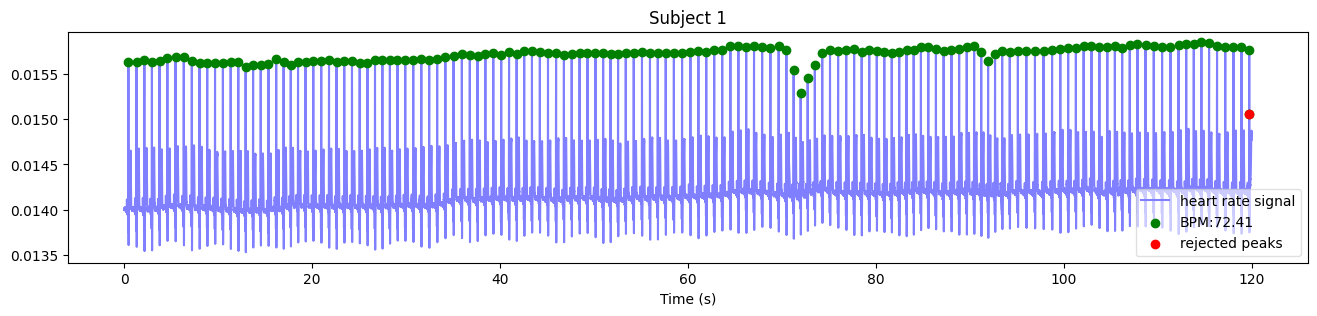

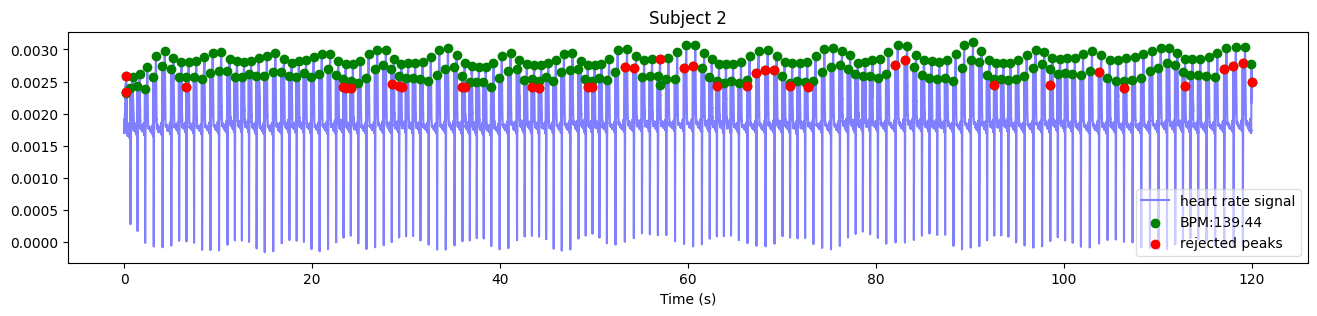

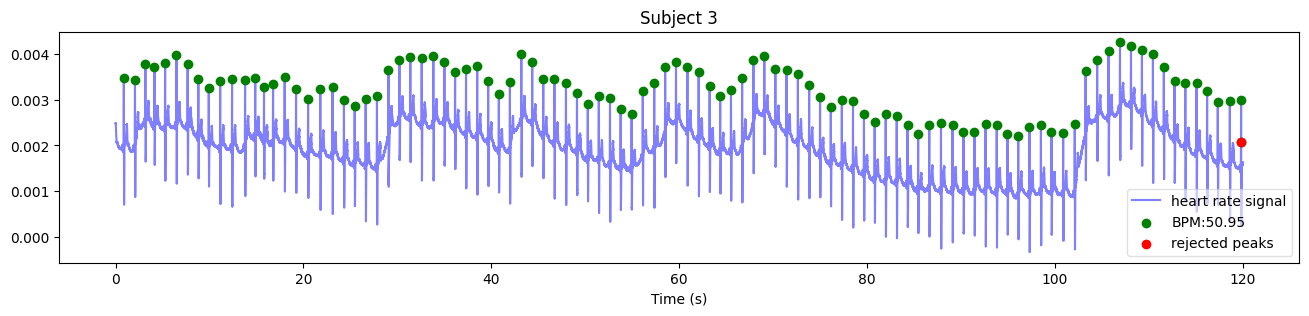

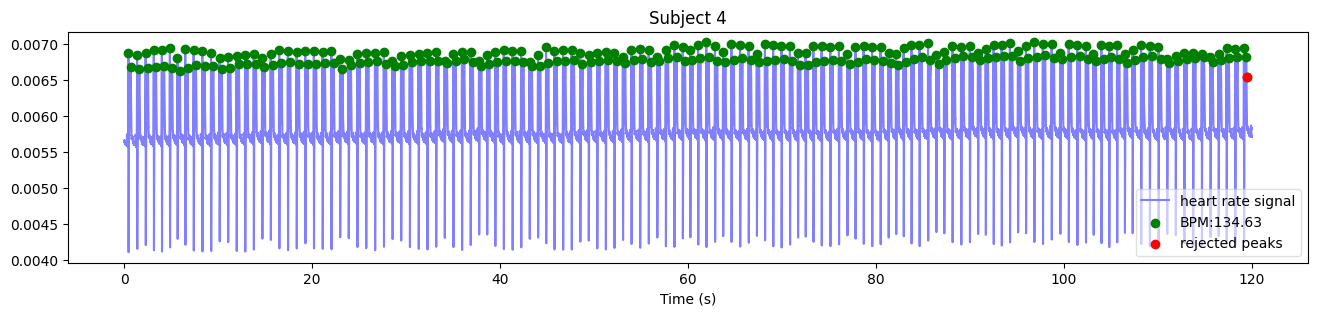

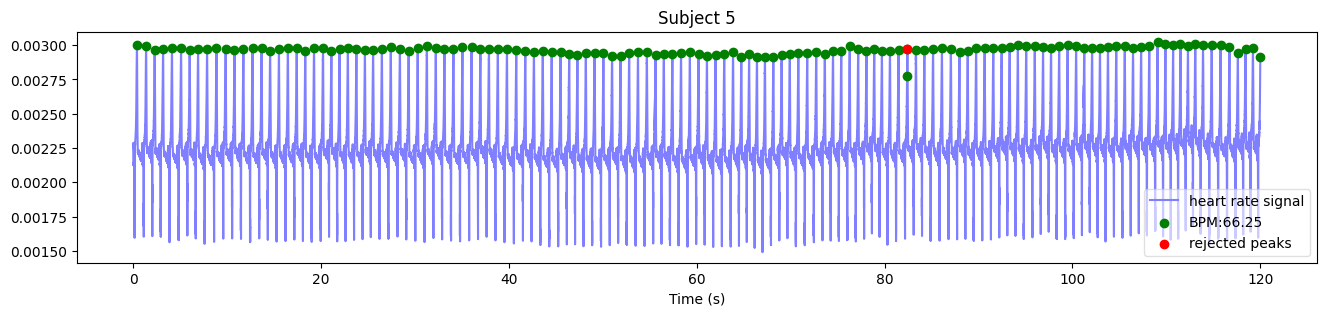

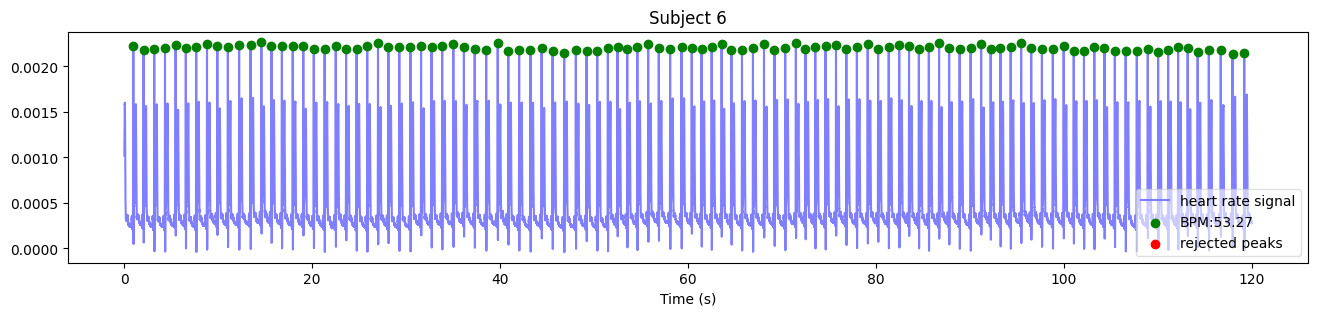

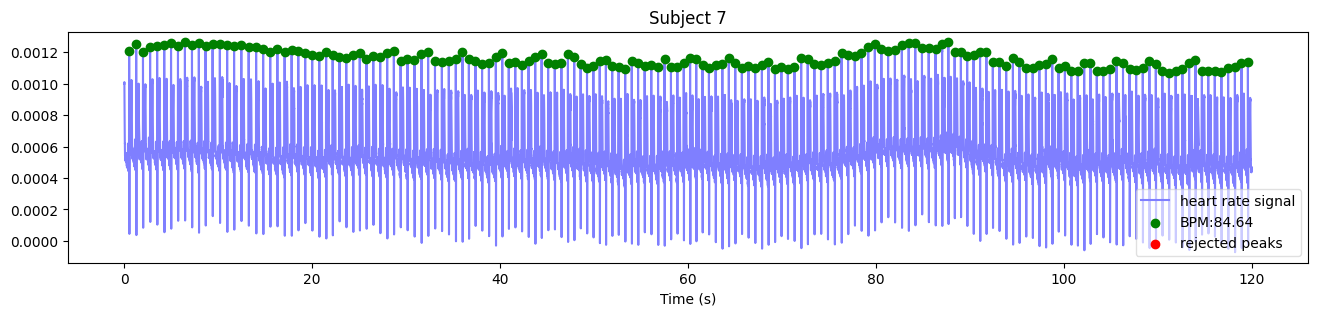

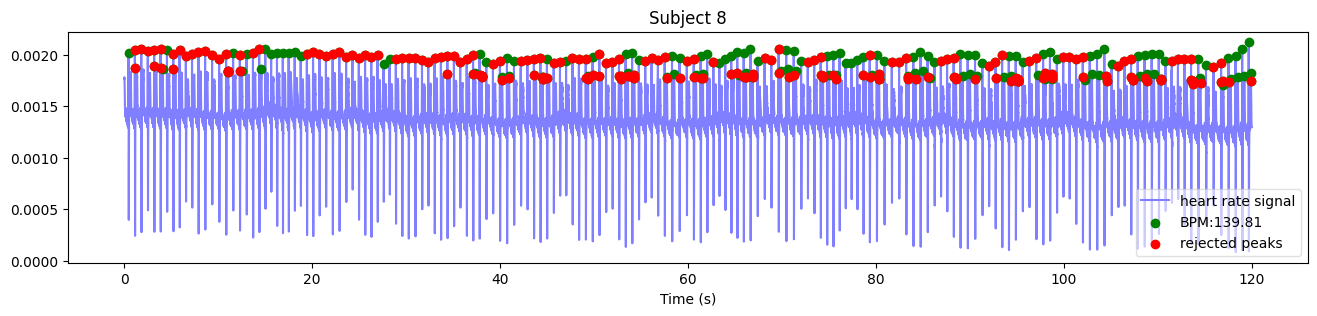

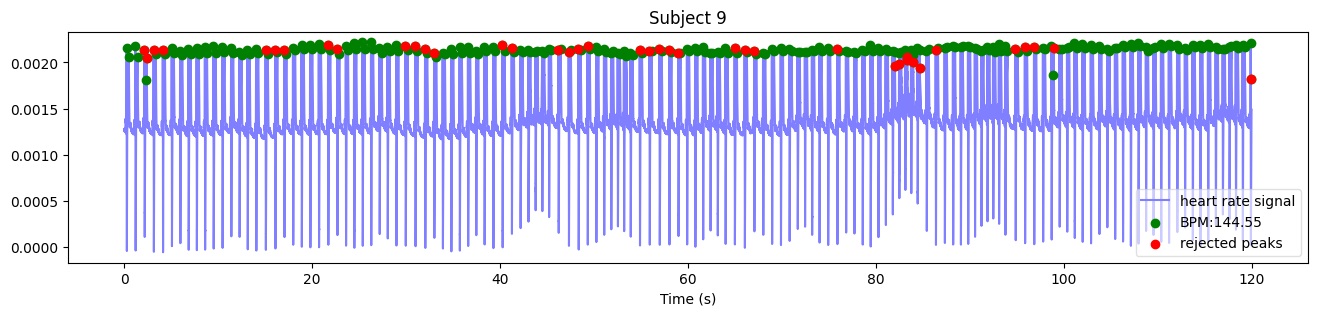

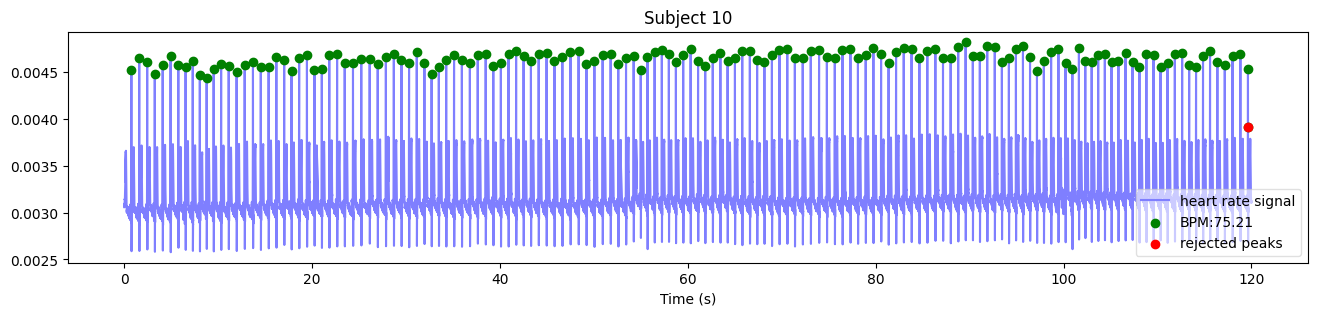

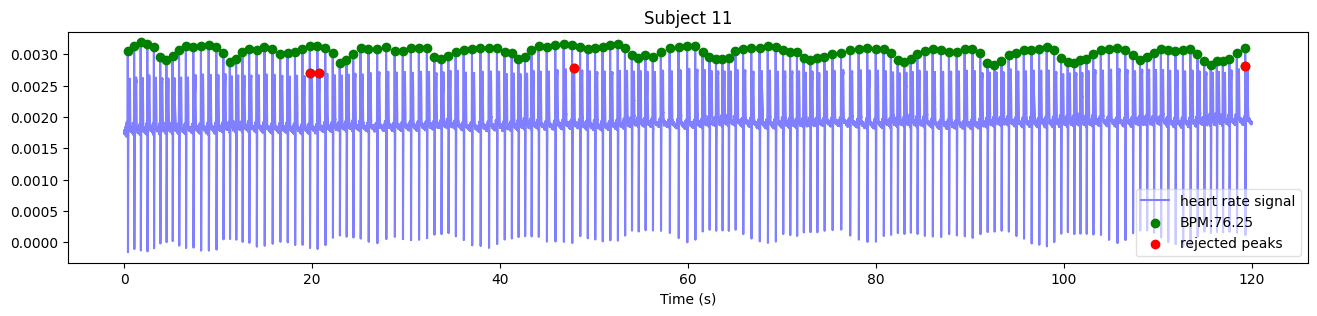

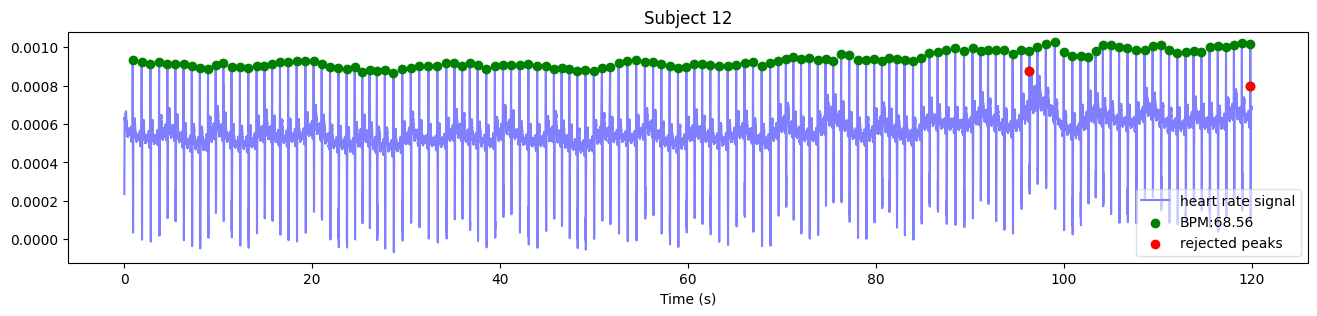

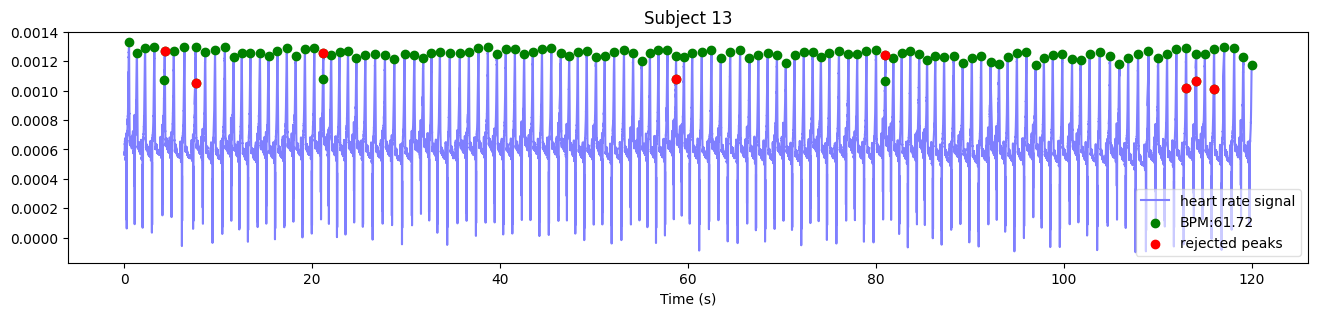

In [6]:
plot_ecg_with_peaks(ECG_data_dict, sample_rate=2048, cols=2)

## Observations:

- For subject 2, 4, 8, 9, the ECG signal look more well defined for the S-wave than the R-wave as the T-wave is more pronounced than usual. In these cases, the peak detection algorithm may not work as expected. 
- This can be prevented by reversing the ECG signal and then applying the peak detection algorithm on the T-waves.
 ECG signal for subject 2, 4, 8, 9 is reversed. 

In [7]:
def apply_flip(ECG_data_dict, flip_flags):    
    flipped_ECG_data_dict = {}
    
    for (key, signal), flip in zip(ECG_data_dict.items(), flip_flags):
        if flip:
            signal_flipped = hp.flip_signal(signal, enhancepeaks=False, keep_range=True)
            flipped_ECG_data_dict[key] = signal_flipped  
        else:
            flipped_ECG_data_dict[key] = signal  
    
    return flipped_ECG_data_dict


In [8]:
flip_signal = [False, True, False, True, False, False, False, True, True, False,
              False, False, False]

ECG_data_preproccesed_dict = apply_flip(ECG_data_dict, flip_signal)

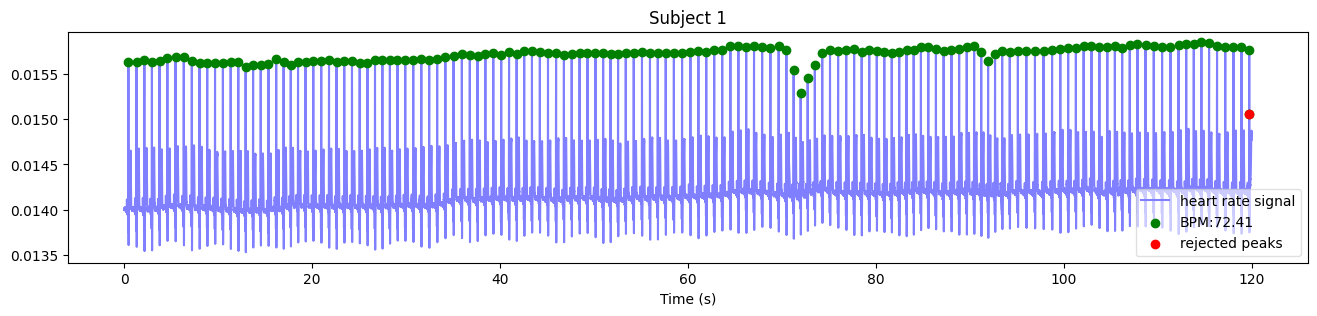

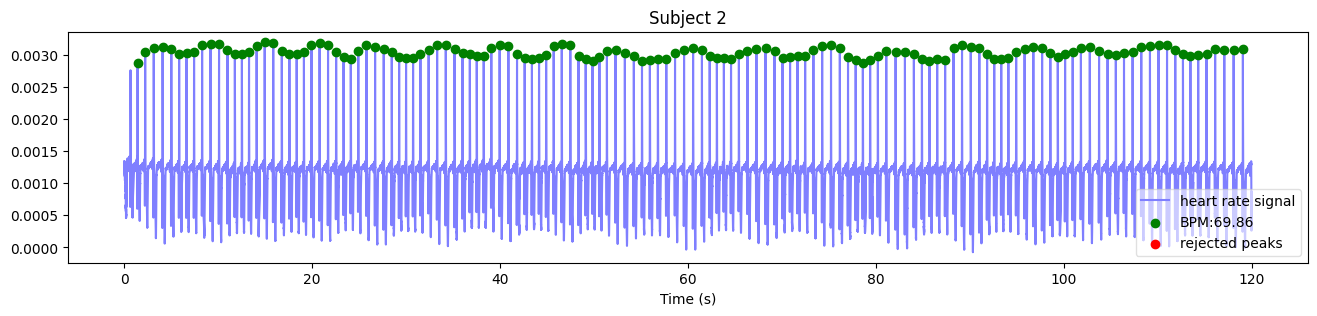

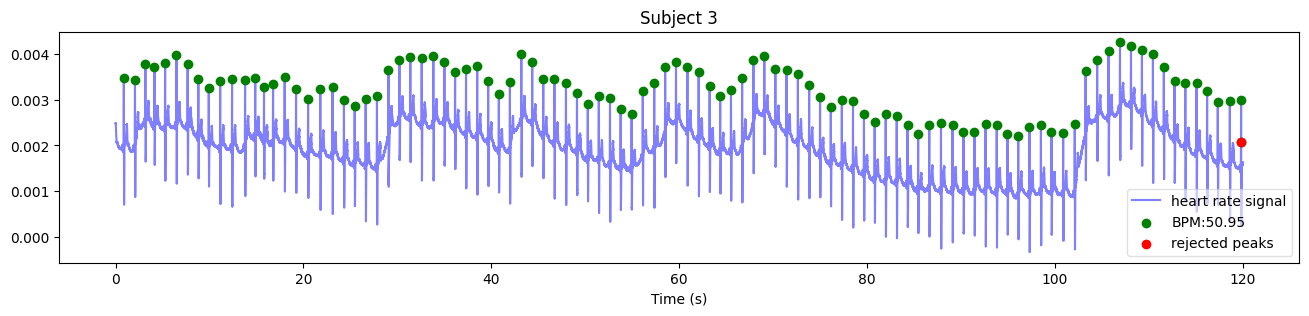

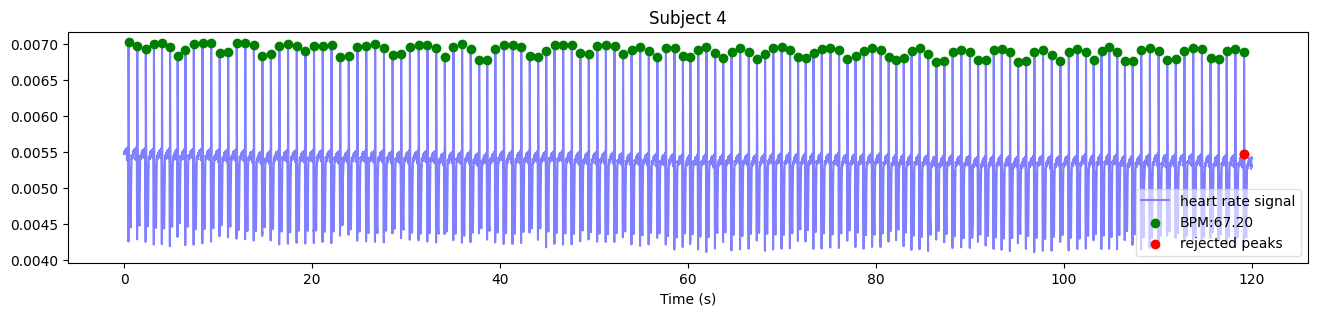

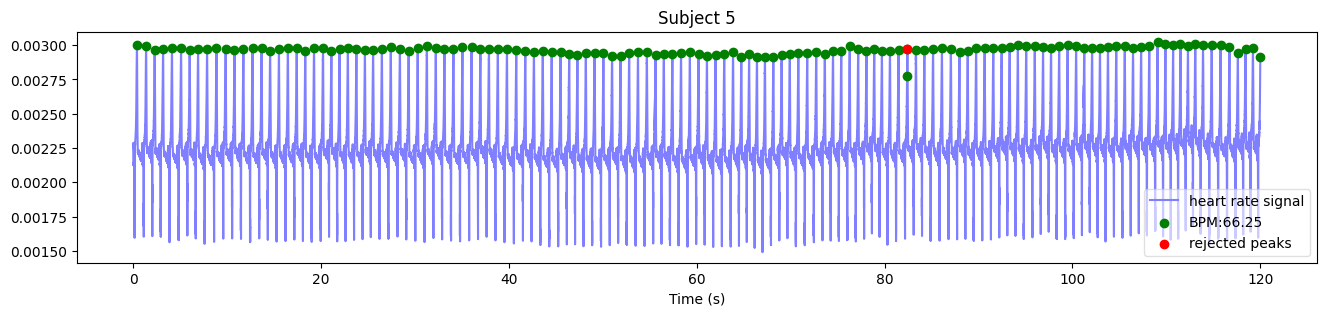

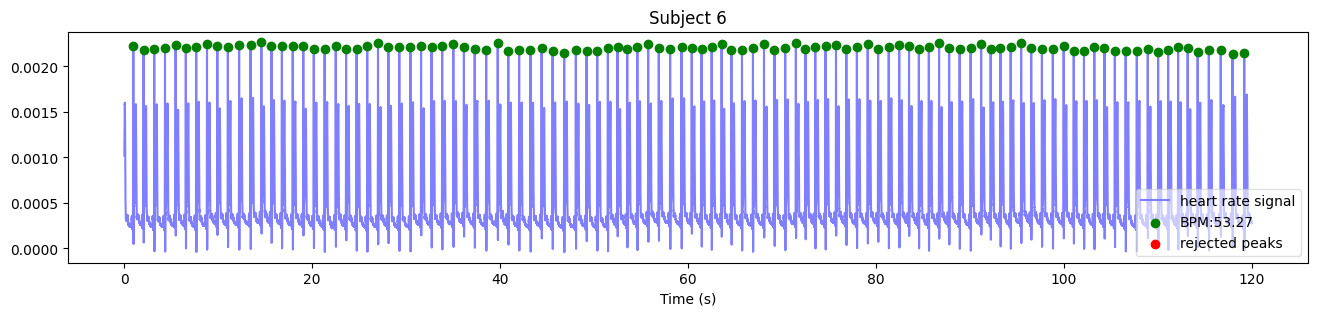

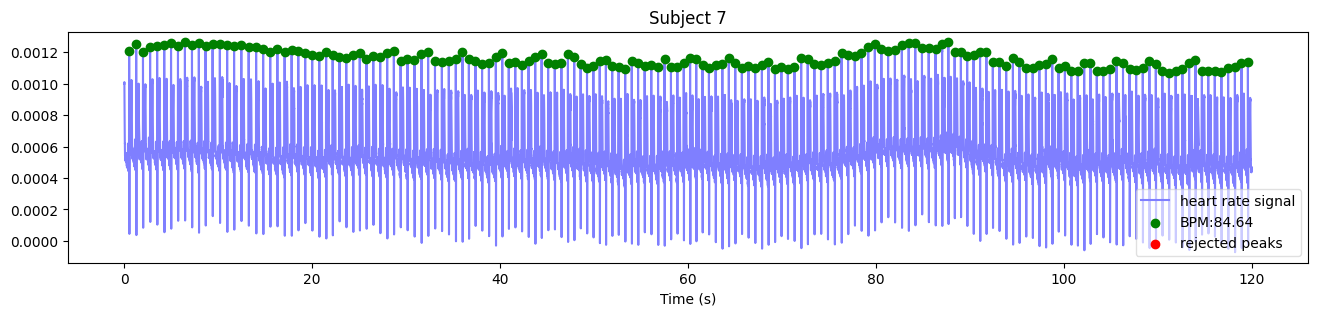

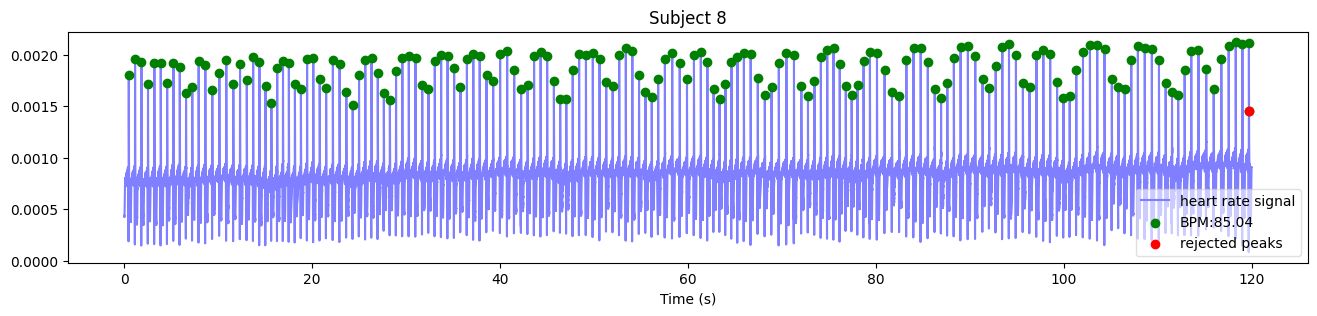

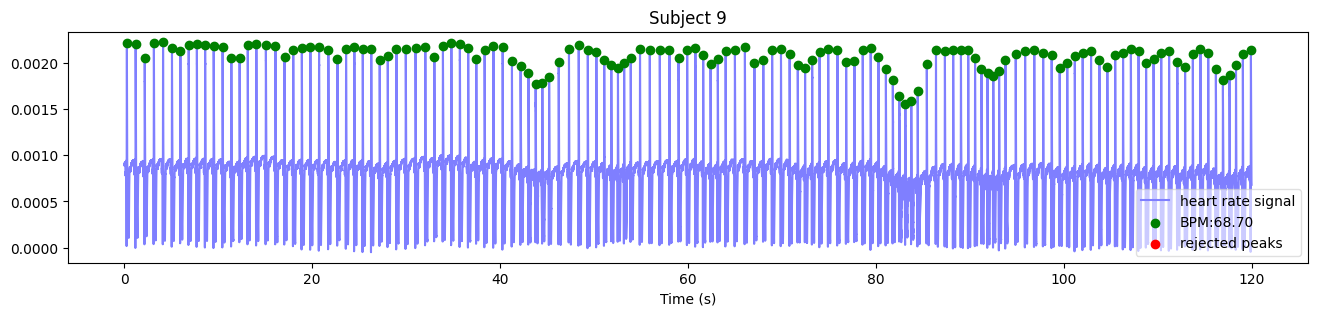

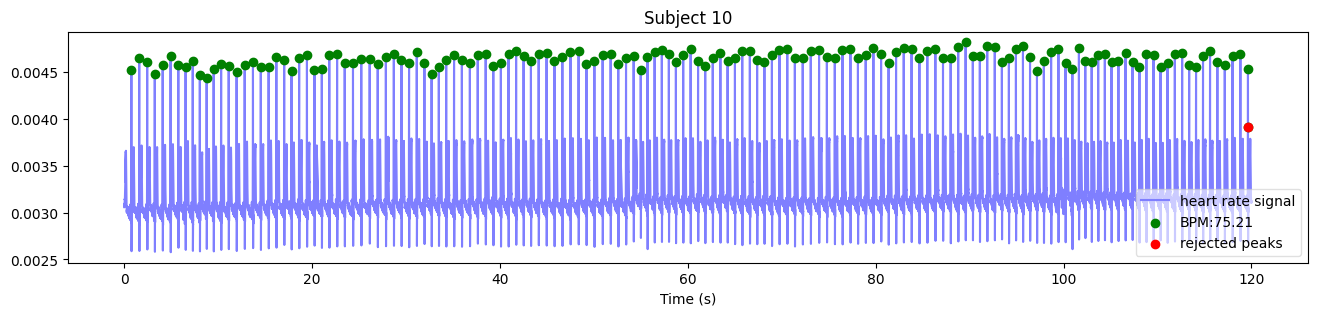

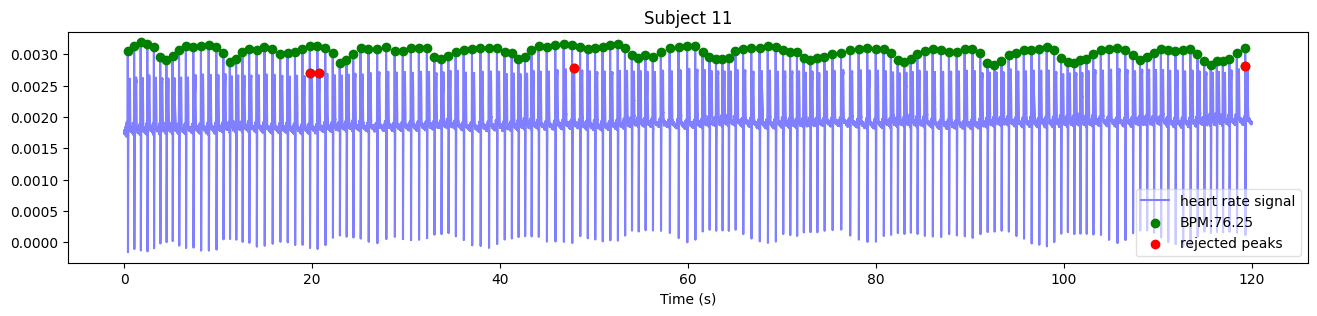

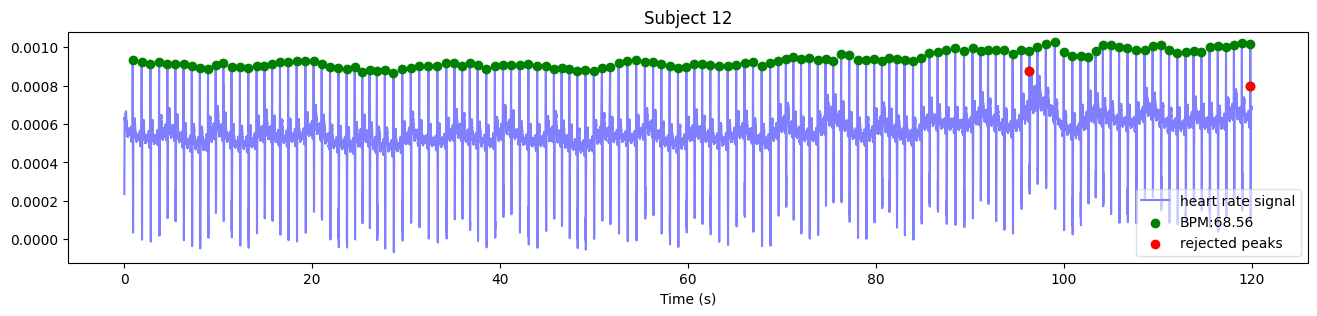

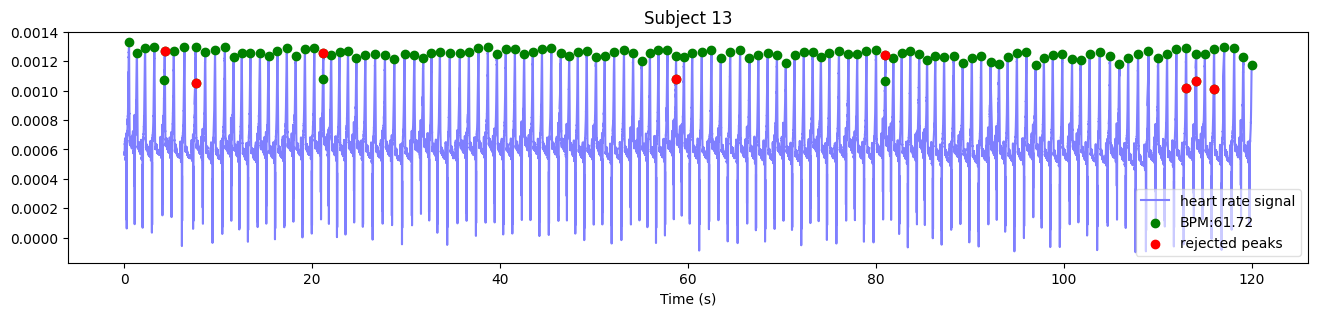

In [9]:
plot_ecg_with_peaks(ECG_data_preproccesed_dict, sample_rate=2048, cols=2)

# Heart rate variability (HRV) analysis

In [10]:
# Get the peaks for each subject
sample_rate = 2048
detected_peaks_dict = {}

for subject in range(len(ECG_data_preproccesed_dict)):
    peaks, m = hp.process(ECG_data_preproccesed_dict[subject+1], sample_rate = sample_rate)
    peak_list = peaks['peaklist'][:-1] # remove the last peak as there is no R-R interval after it - so difficult to determine the RR interval
    time_list = [peak / sample_rate for peak in peak_list] # Calculate corresponding times for the peaks

    detected_peaks_dict[subject+1] = {'peaks': peak_list, 'times': time_list}
    
    heart_rate = []
    for peak in range(len(peak_list)-1):    
        heart_rate_seconds = (peak_list[peak+1]-peak_list[peak])/sample_rate 
        heart_rate_pr_minute = (1 / heart_rate_seconds) * 60
        heart_rate.append(heart_rate_pr_minute)
    
    detected_peaks_dict[subject+1]['heart_rate'] = heart_rate

/Users/jasmink.j.thari/Documents/anaconda3/envs/env_ecg/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/jasmink.j.thari/Documents/anaconda3/envs/env_ecg/lib/python3.11/site-packages/numpy/_core/_methods.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jasmink.j.thari/Documents/anaconda3/envs/env_ecg/lib/python3.11/site-packages/numpy/ma/core.py:5437: RuntimeWarning: Mean of empty slice.
  result = super().mean(axis=axis, dtype=dtype, **kwargs)[()]
/Users/jasmink.j.thari/Documents/anaconda3/envs/env_ecg/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:4318: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


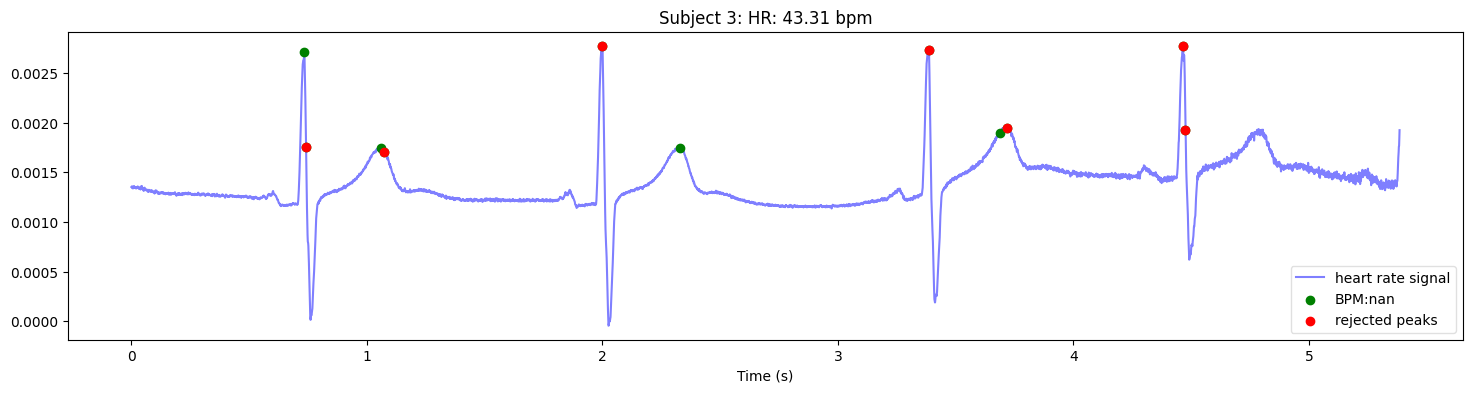

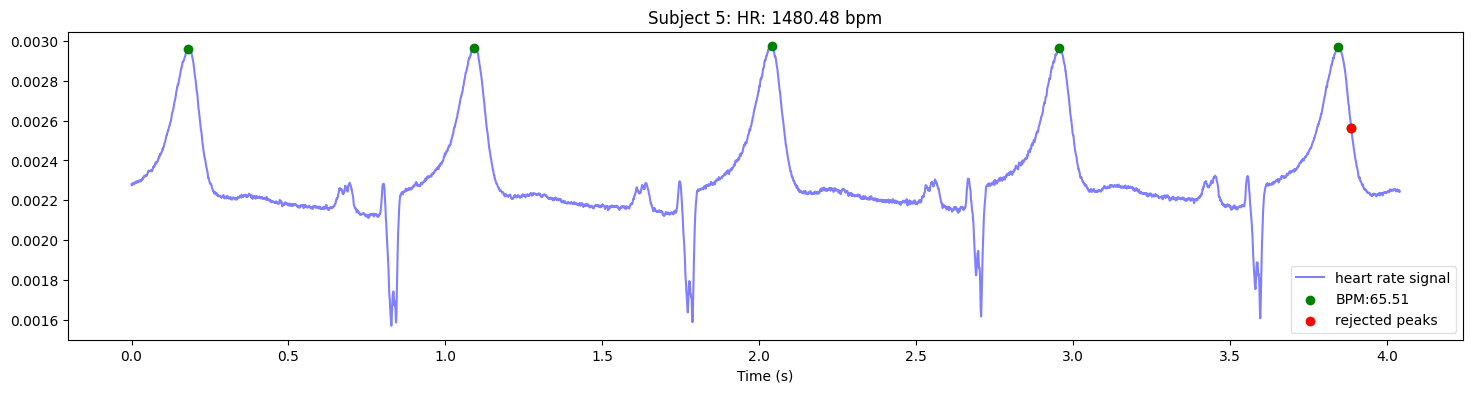

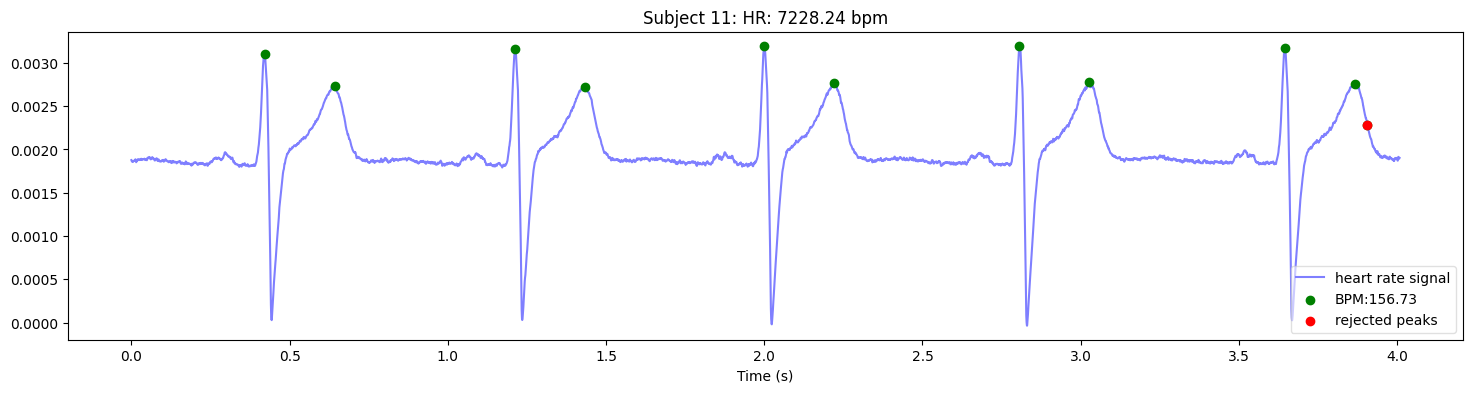

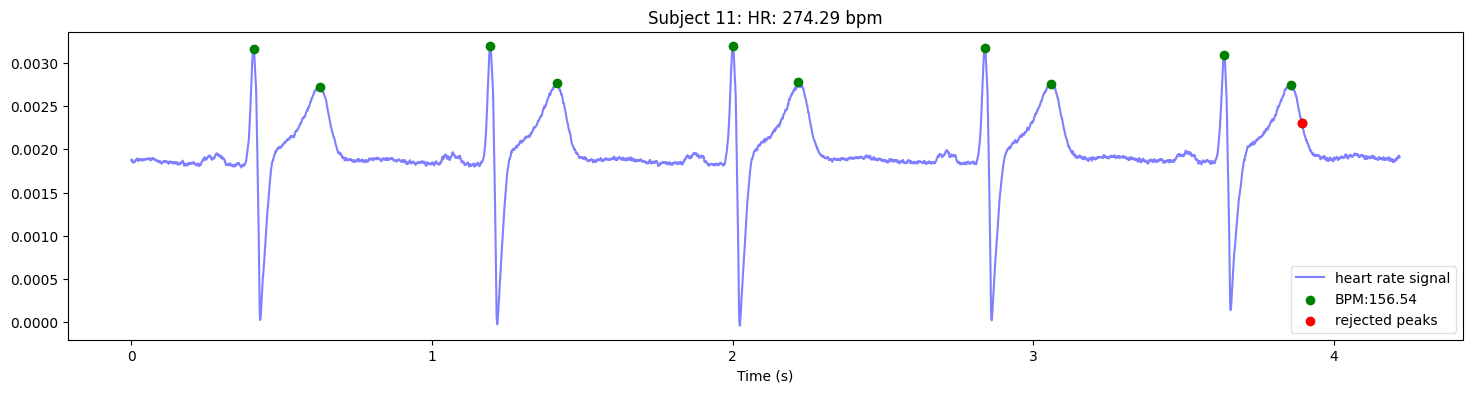

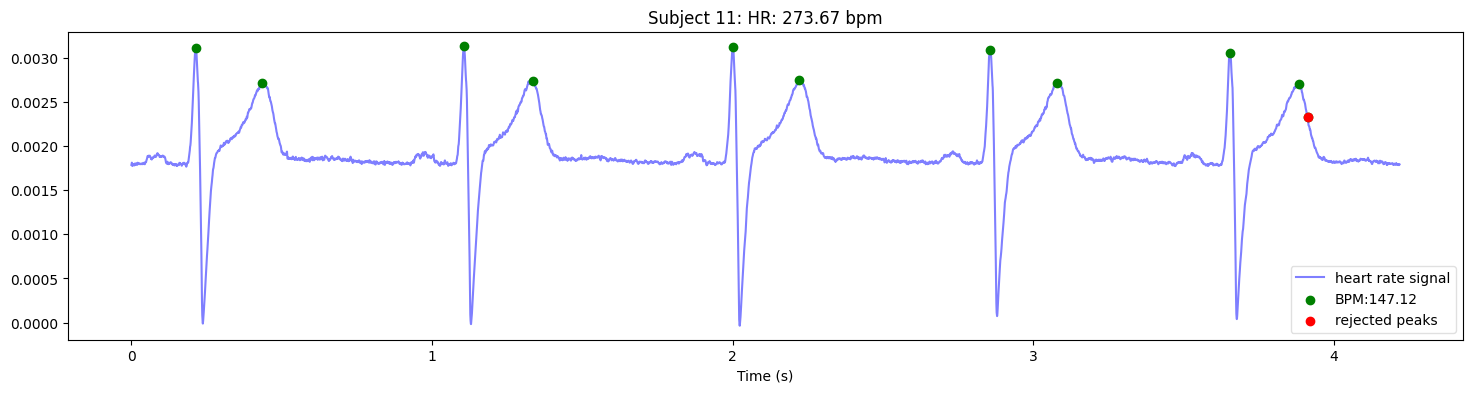

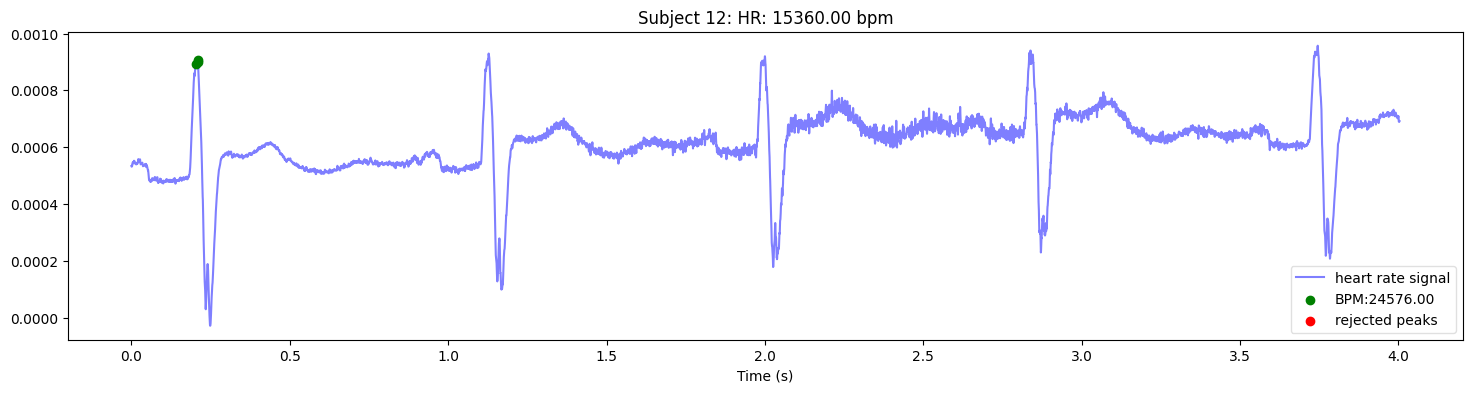

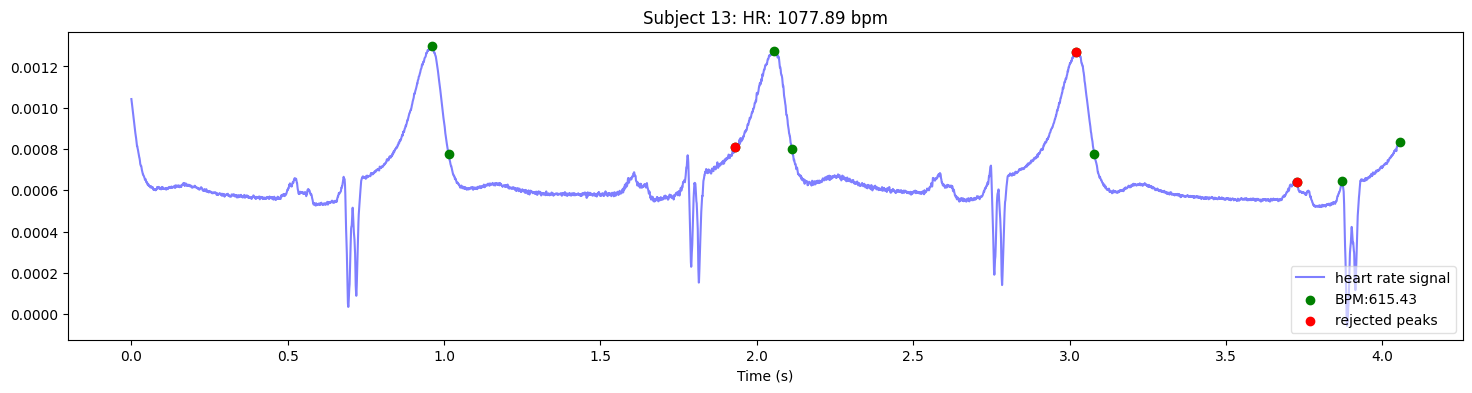

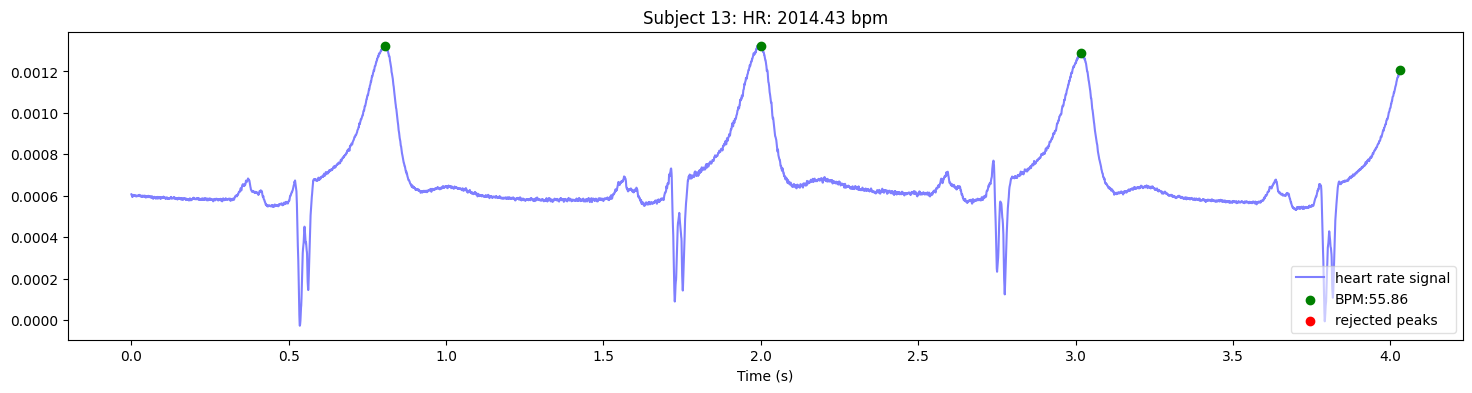

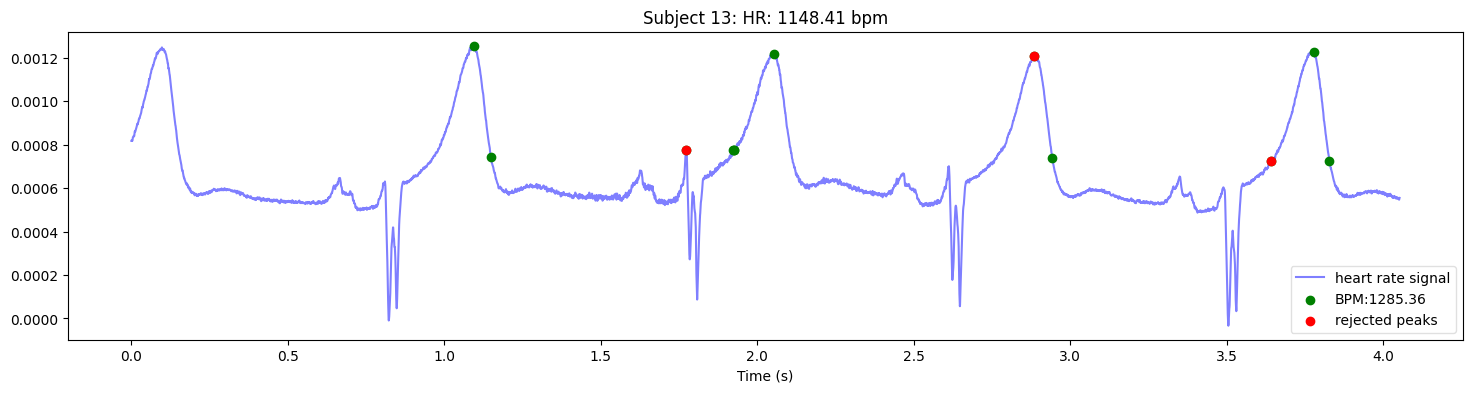

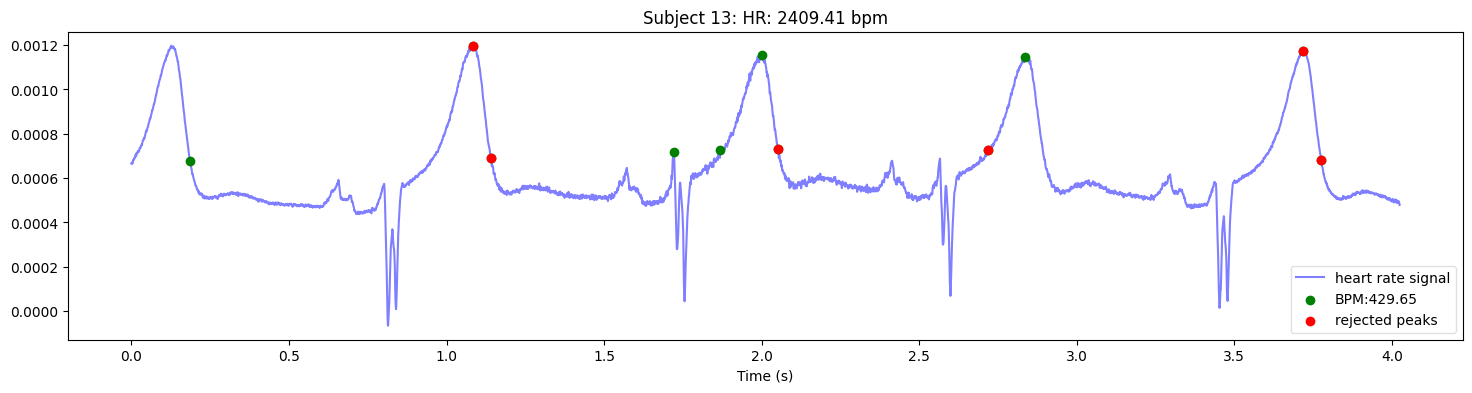

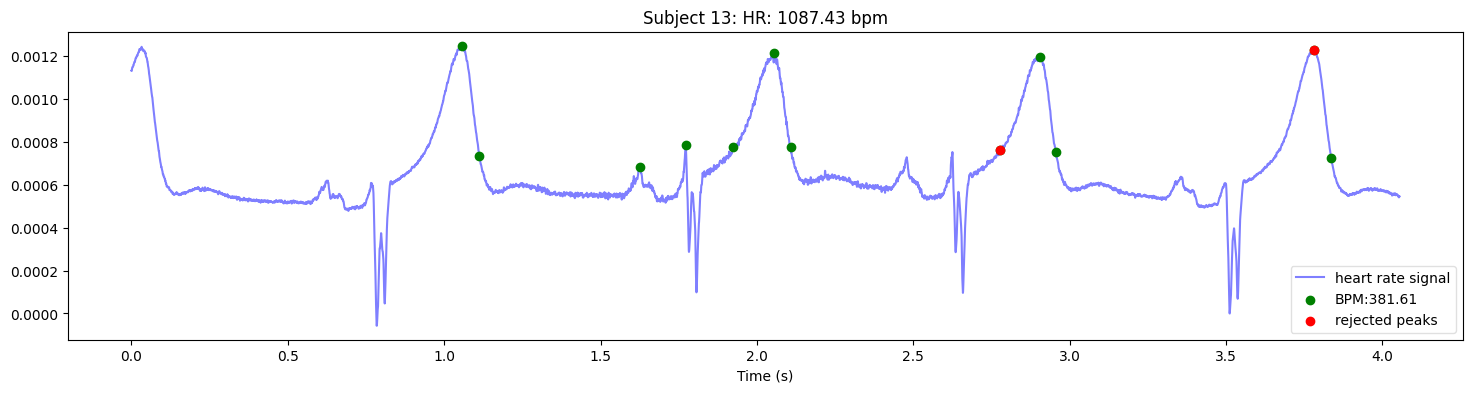

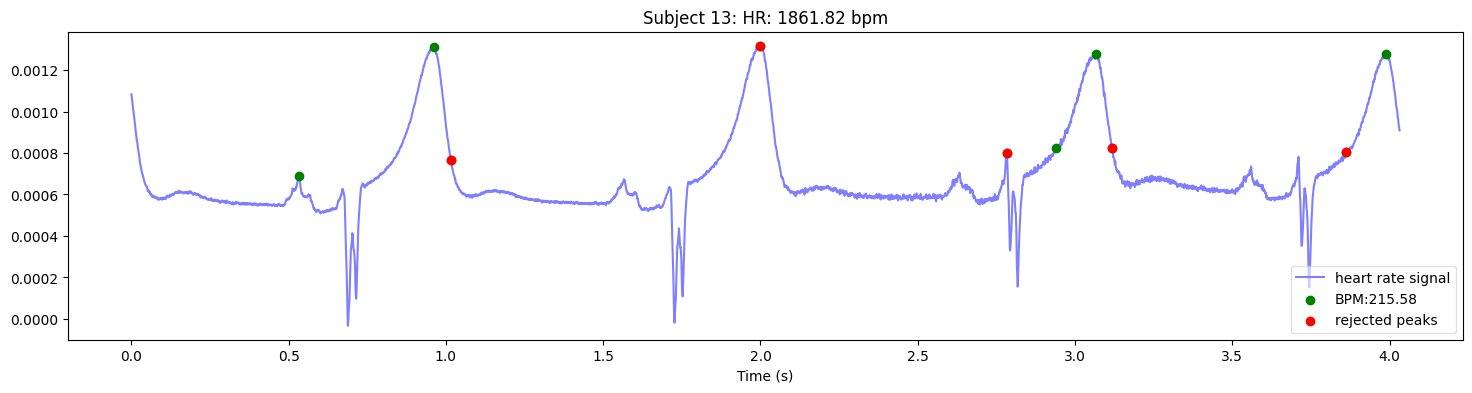

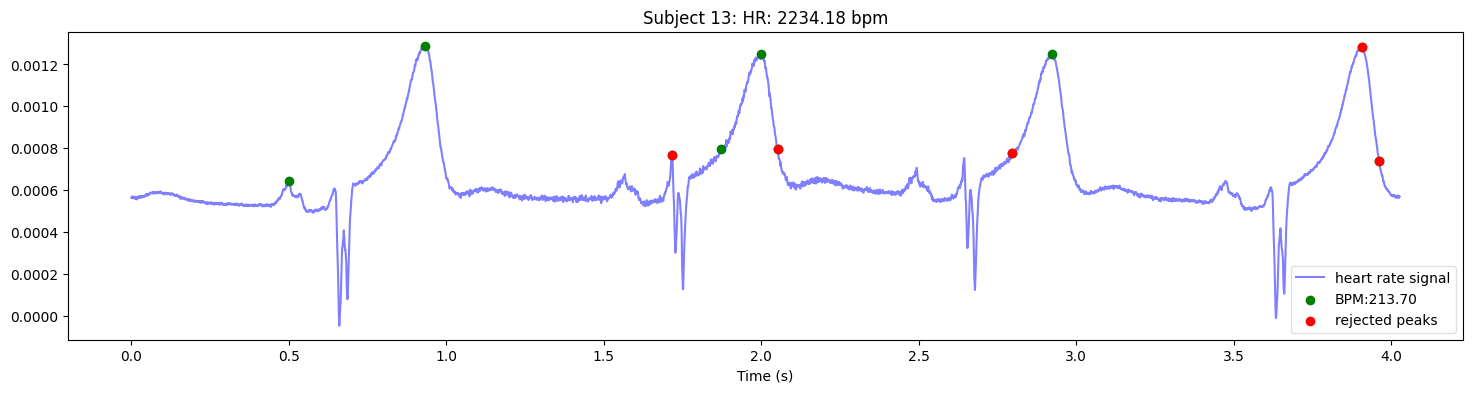

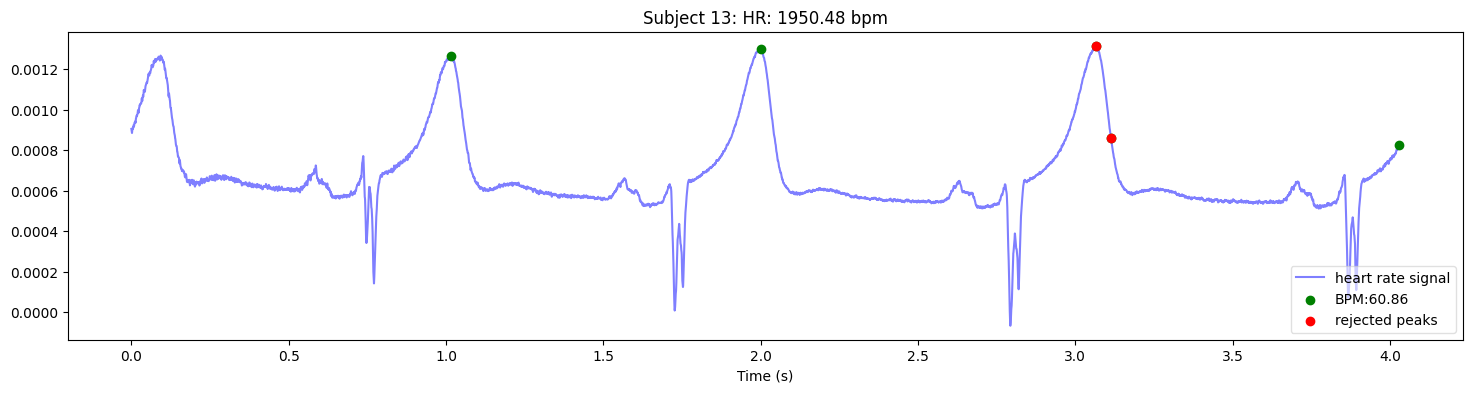

In [11]:
for subject in range(len(detected_peaks_dict)):
    peaks = detected_peaks_dict[subject+1]['peaks'][:-1]
    heart_rates = detected_peaks_dict[subject+1]['heart_rate']
    for (idx_peak, _), heart_rate in zip(enumerate(peaks), heart_rates):
        if (heart_rate < 45) or (heart_rate >= 100):
            # Define the ECG segment around the detected peak
            peaks_out, m_out = hp.process(ECG_data_preproccesed_dict[subject+1][peaks[idx_peak]-2048*2:peaks[idx_peak+1]+2048*2], sample_rate = sample_rate)
            # Plot the ECG for this segment
            hp.plotter(peaks_out, m_out, show=False, title=f'Subject {subject+1}: HR: {heart_rate:.2f} bpm', figsize=(18, 4))

In [12]:
all_heart_rates_manipulated = [detected_peaks_dict[subject+1]['heart_rate'] for subject in range(len(detected_peaks_dict))]
for j, person in enumerate(all_heart_rates_manipulated): 
    for i, heart_rate in enumerate(person): 
        if heart_rate >= 100: 
            all_heart_rates_manipulated[j][i] = person[i-1] 
        if heart_rate <= 45:
            all_heart_rates_manipulated[j][i] = person[i-1] 

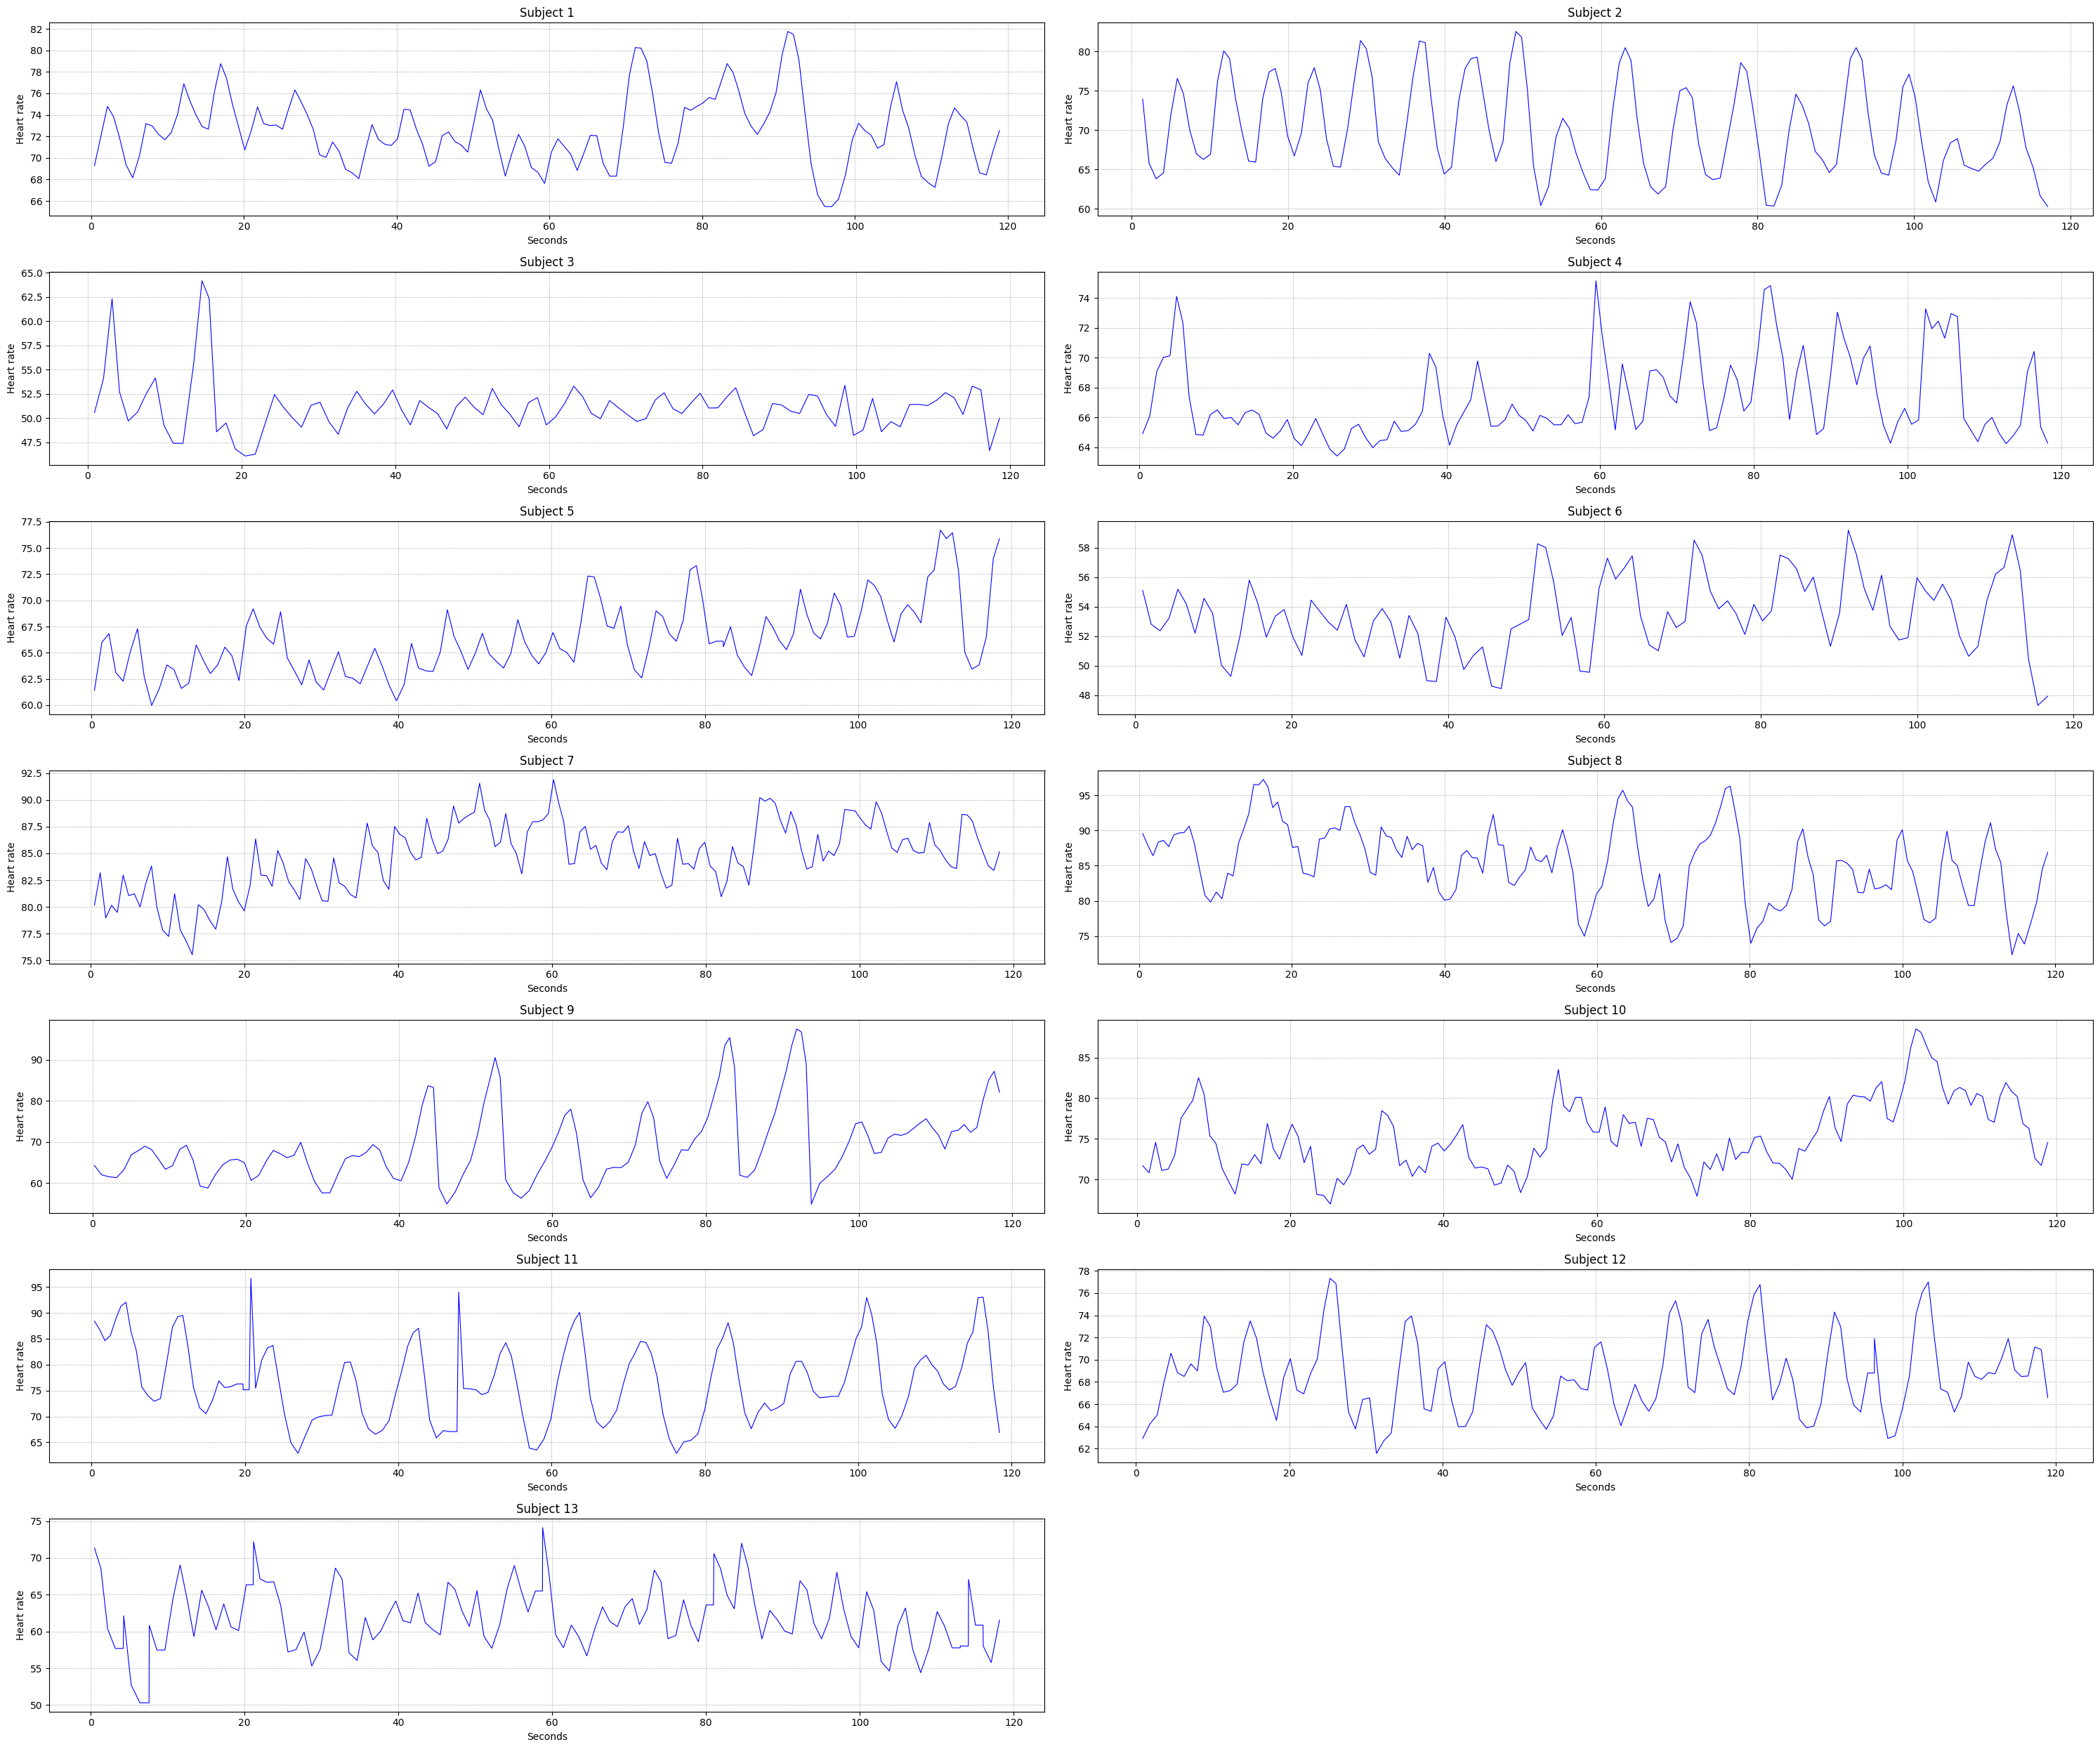

In [13]:
n_subjects = len(ECG_data_dict)
cols = 2  
rows = math.ceil(n_subjects / cols) 

peaks_seconds = [detected_peaks_dict[subject+1]['times'] for subject in range(len(detected_peaks_dict))]

plt.figure(figsize=(30, 25)) 

for i in range(1, n_subjects + 1):
    heart_rate = all_heart_rates_manipulated[i-1]
    peaks = peaks_seconds[i-1][:-1]
    plt.subplot(rows, cols, i)   
     
    plt.plot(peaks, heart_rate, color='blue', linewidth=0.8)
    plt.title(f'Subject {i}', fontsize=12)
    plt.xlabel('Seconds', fontsize=10)
    plt.ylabel('Heart rate', fontsize=10)
    plt.grid(True, linestyle='--', linewidth=0.5)
   
plt.tight_layout()
plt.show()

# Variance in 10 seconds

In [14]:
# Get the peaks for each subject
sample_rate = 2048
seconds = 10
start_time = 70 * sample_rate

heart_rate_10_seconds_dict = {}
for subject in range(len(ECG_data_preproccesed_dict)):
    peaks, m = hp.process(ECG_data_preproccesed_dict[subject+1][start_time:start_time+sample_rate*seconds], sample_rate = sample_rate)
    peak_list = peaks['peaklist'][:-1] # remove the last peak as there is no R-R interval after it - so difficult to determine the RR interval
    time_list = [peak / sample_rate for peak in peak_list] # Calculate corresponding times for the peaks

    heart_rate_10_seconds_dict[subject+1] = {'peaks': peak_list, 'times': time_list}
    heart_rate = []
    for peak in range(len(peak_list)-1):    
        heart_rate_seconds = (peak_list[peak+1]-peak_list[peak])/sample_rate 
        heart_rate_pr_minute = (1 / heart_rate_seconds) * 60
        heart_rate.append(heart_rate_pr_minute)
    
    heart_rate_10_seconds_dict[subject+1]['heart_rate_10sec'] = heart_rate

In [15]:
all_heart_rates_manipulated_10sec = [heart_rate_10_seconds_dict[subject+1]['heart_rate_10sec'] for subject in range(len(heart_rate_10_seconds_dict))]
for j, person in enumerate(all_heart_rates_manipulated_10sec): 
    for i, heart_rate in enumerate(person): 
        if heart_rate >= 150: 
            all_heart_rates_manipulated_10sec[j][i] = person[i-1] 

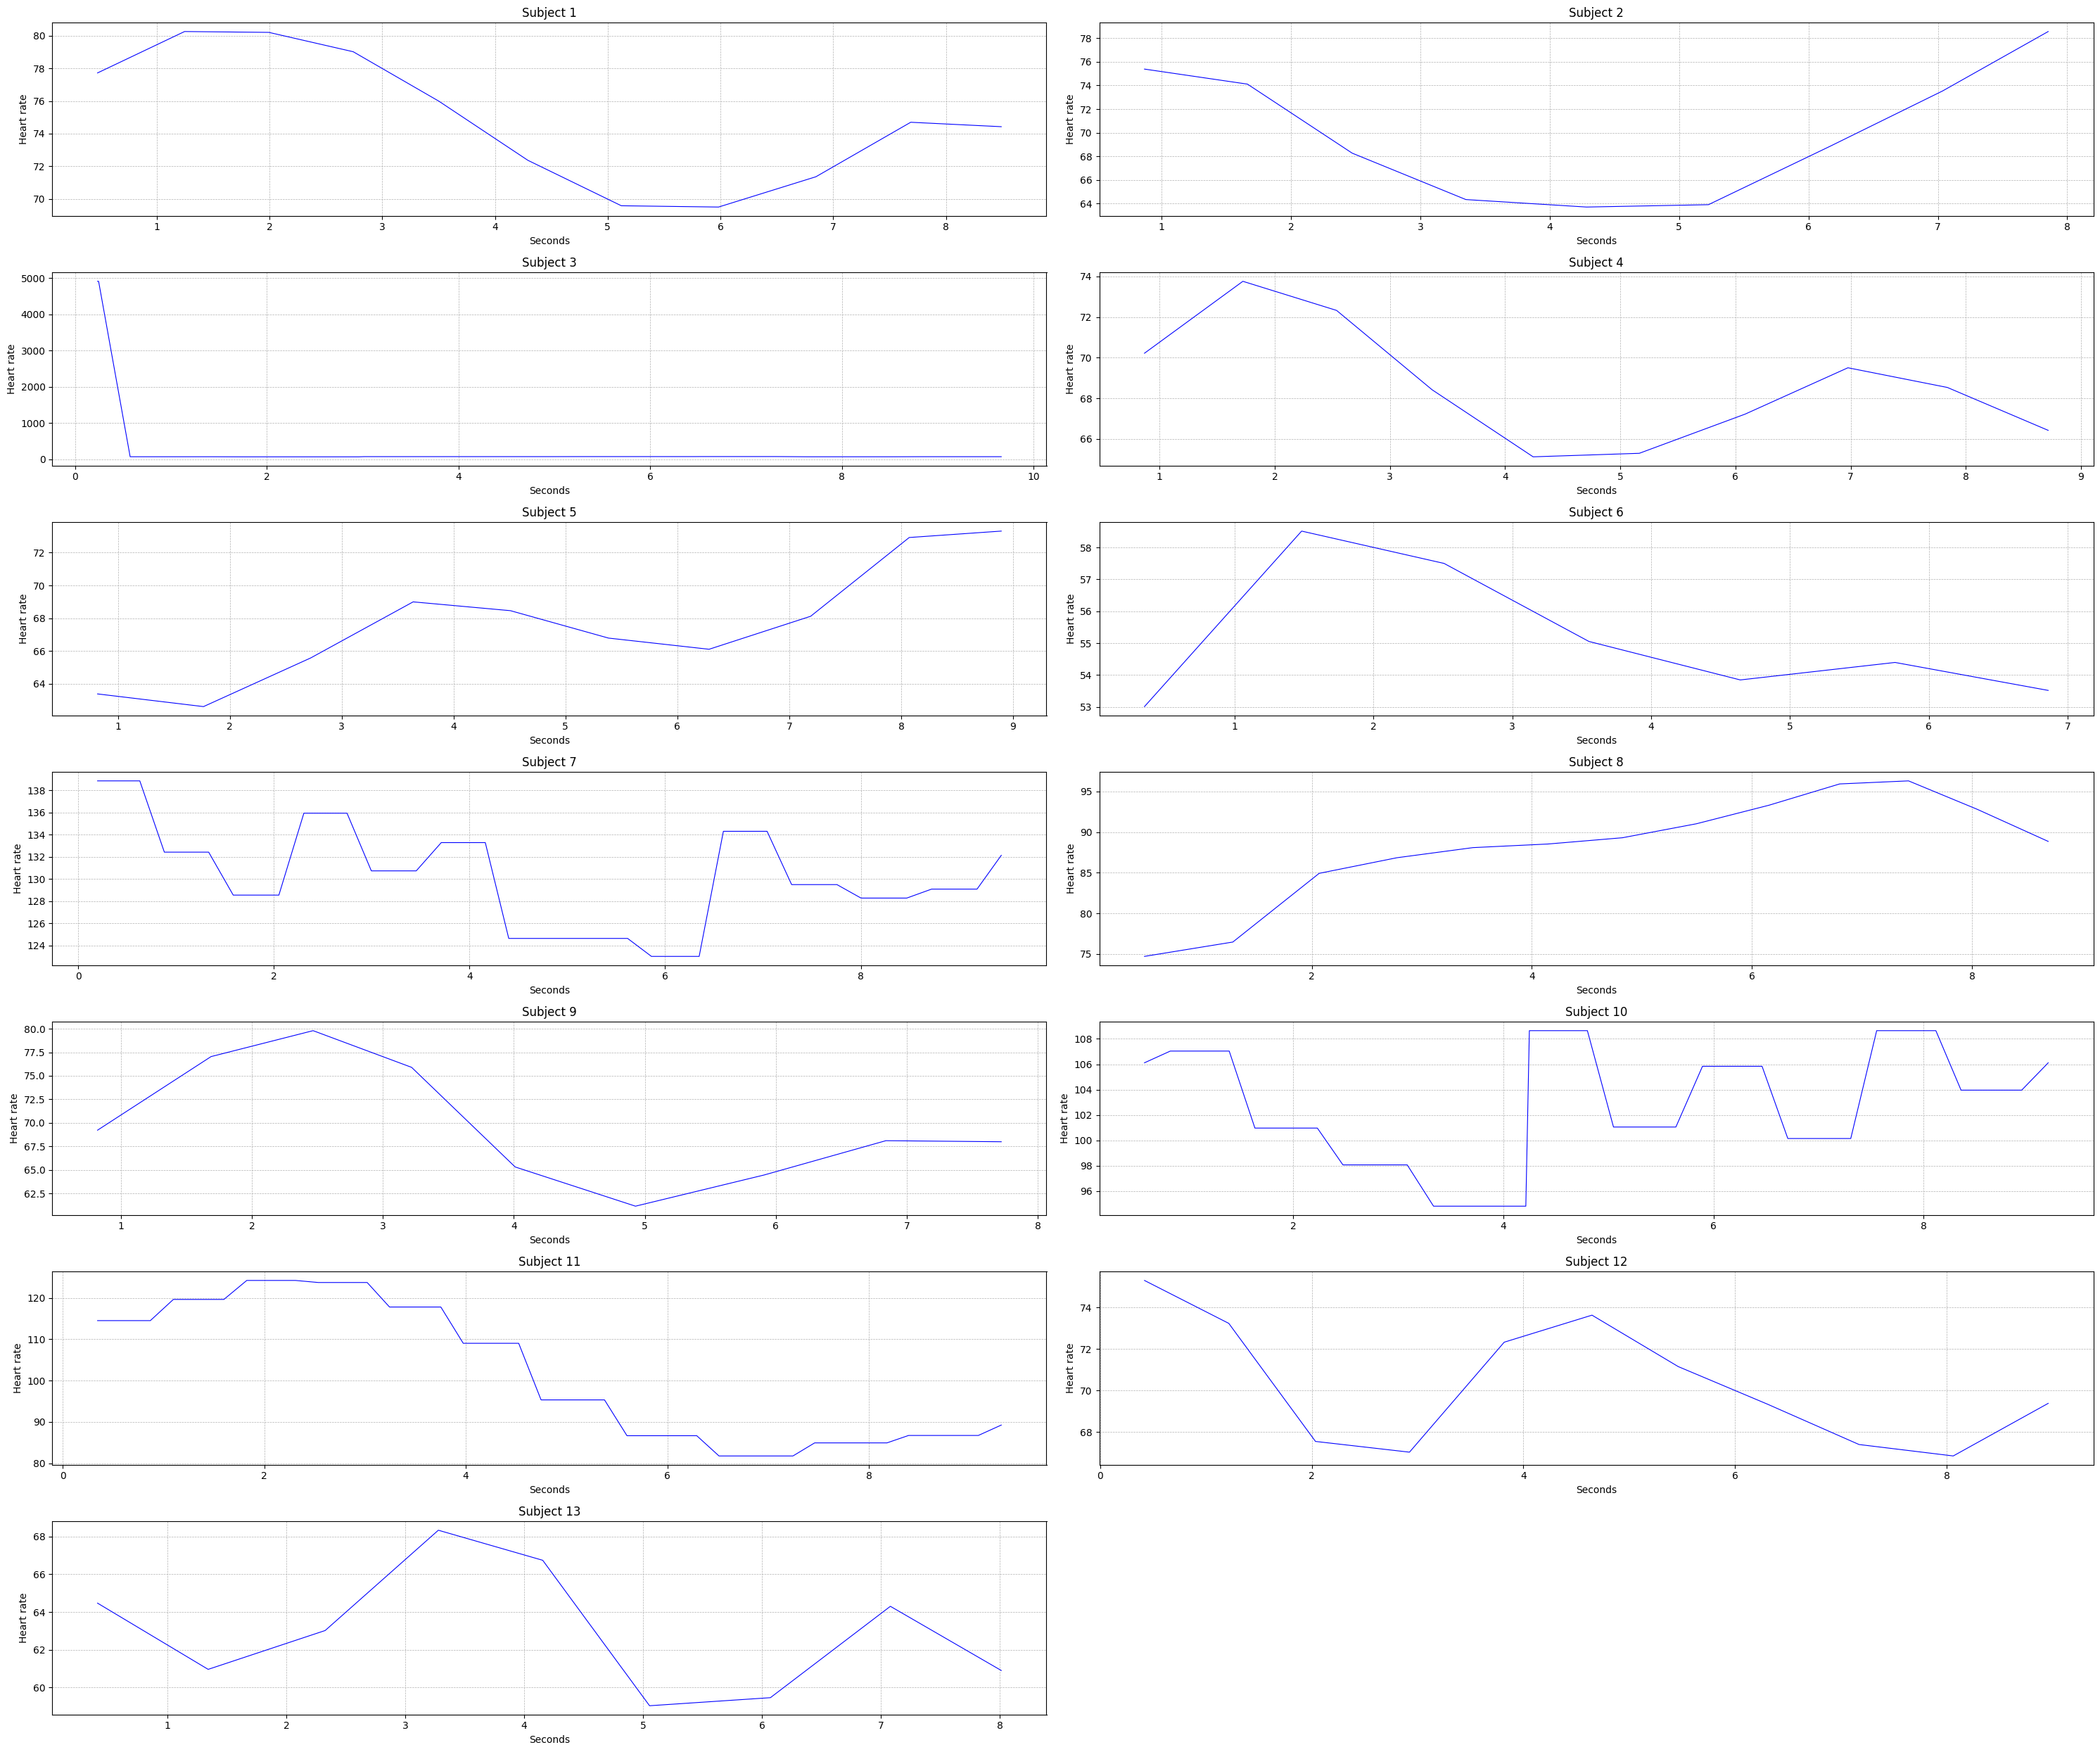

In [16]:
n_subjects = len(ECG_data_dict)
cols = 2  
rows = math.ceil(n_subjects / cols) 

peaks_seconds = [heart_rate_10_seconds_dict[subject+1]['times'] for subject in range(len(heart_rate_10_seconds_dict))]

plt.figure(figsize=(30, 25)) 

for i in range(1, n_subjects + 1):
    heart_rate = all_heart_rates_manipulated_10sec[i-1]
    peaks = peaks_seconds[i-1][:-1]
    plt.subplot(rows, cols, i)   
     
    plt.plot(peaks, heart_rate, color='blue', linewidth=0.8)
    plt.title(f'Subject {i}', fontsize=12)
    plt.xlabel('Seconds', fontsize=10)
    plt.ylabel('Heart rate', fontsize=10)
    plt.grid(True, linestyle='--', linewidth=0.5)
   
plt.tight_layout()
plt.show()

# Interpolation of RR intervals

In [140]:
def extract_RR_peaks(ECG_data_dict, sample_rate=2048):
    RR_Peaks_dict = {}   
    invalid_intervals_dict =  {key: {} for key in ECG_data_dict.keys()}
    peaks_dict = {}         

    for idx, (key, signal) in enumerate(ECG_data_dict.items()):
        # Process the signal to get peaks and measures
        peaks, m = hp.process(signal, sample_rate=sample_rate)
        RR_intervals_ms = peaks['RR_list']  
        peaklist = peaks['peaklist'][:-1]          

        # Store the RR intervals and peak indices in the dictionaries
        RR_Peaks_dict[key] = RR_intervals_ms
        peaks_dict[key] = peaklist

        # Find intervals outside the range [600, 1400] ms
        invalid_values = [rr for rr in RR_intervals_ms if rr < 600 or rr > 1400]
        invalid_mask = np.isin(RR_intervals_ms, invalid_values)
        invalid_intervals_dict[key]['mask'] = invalid_mask
        
        # If there are any invalid values, log them
        if invalid_values:
            invalid_intervals_dict[key]['invalid'] = invalid_values
            

    return RR_Peaks_dict, invalid_intervals_dict, peaks_dict

In [141]:
RR_Peaks_dict, invalid_intervals_dict, peaks_dict = extract_RR_peaks(ECG_data_preproccesed_dict)

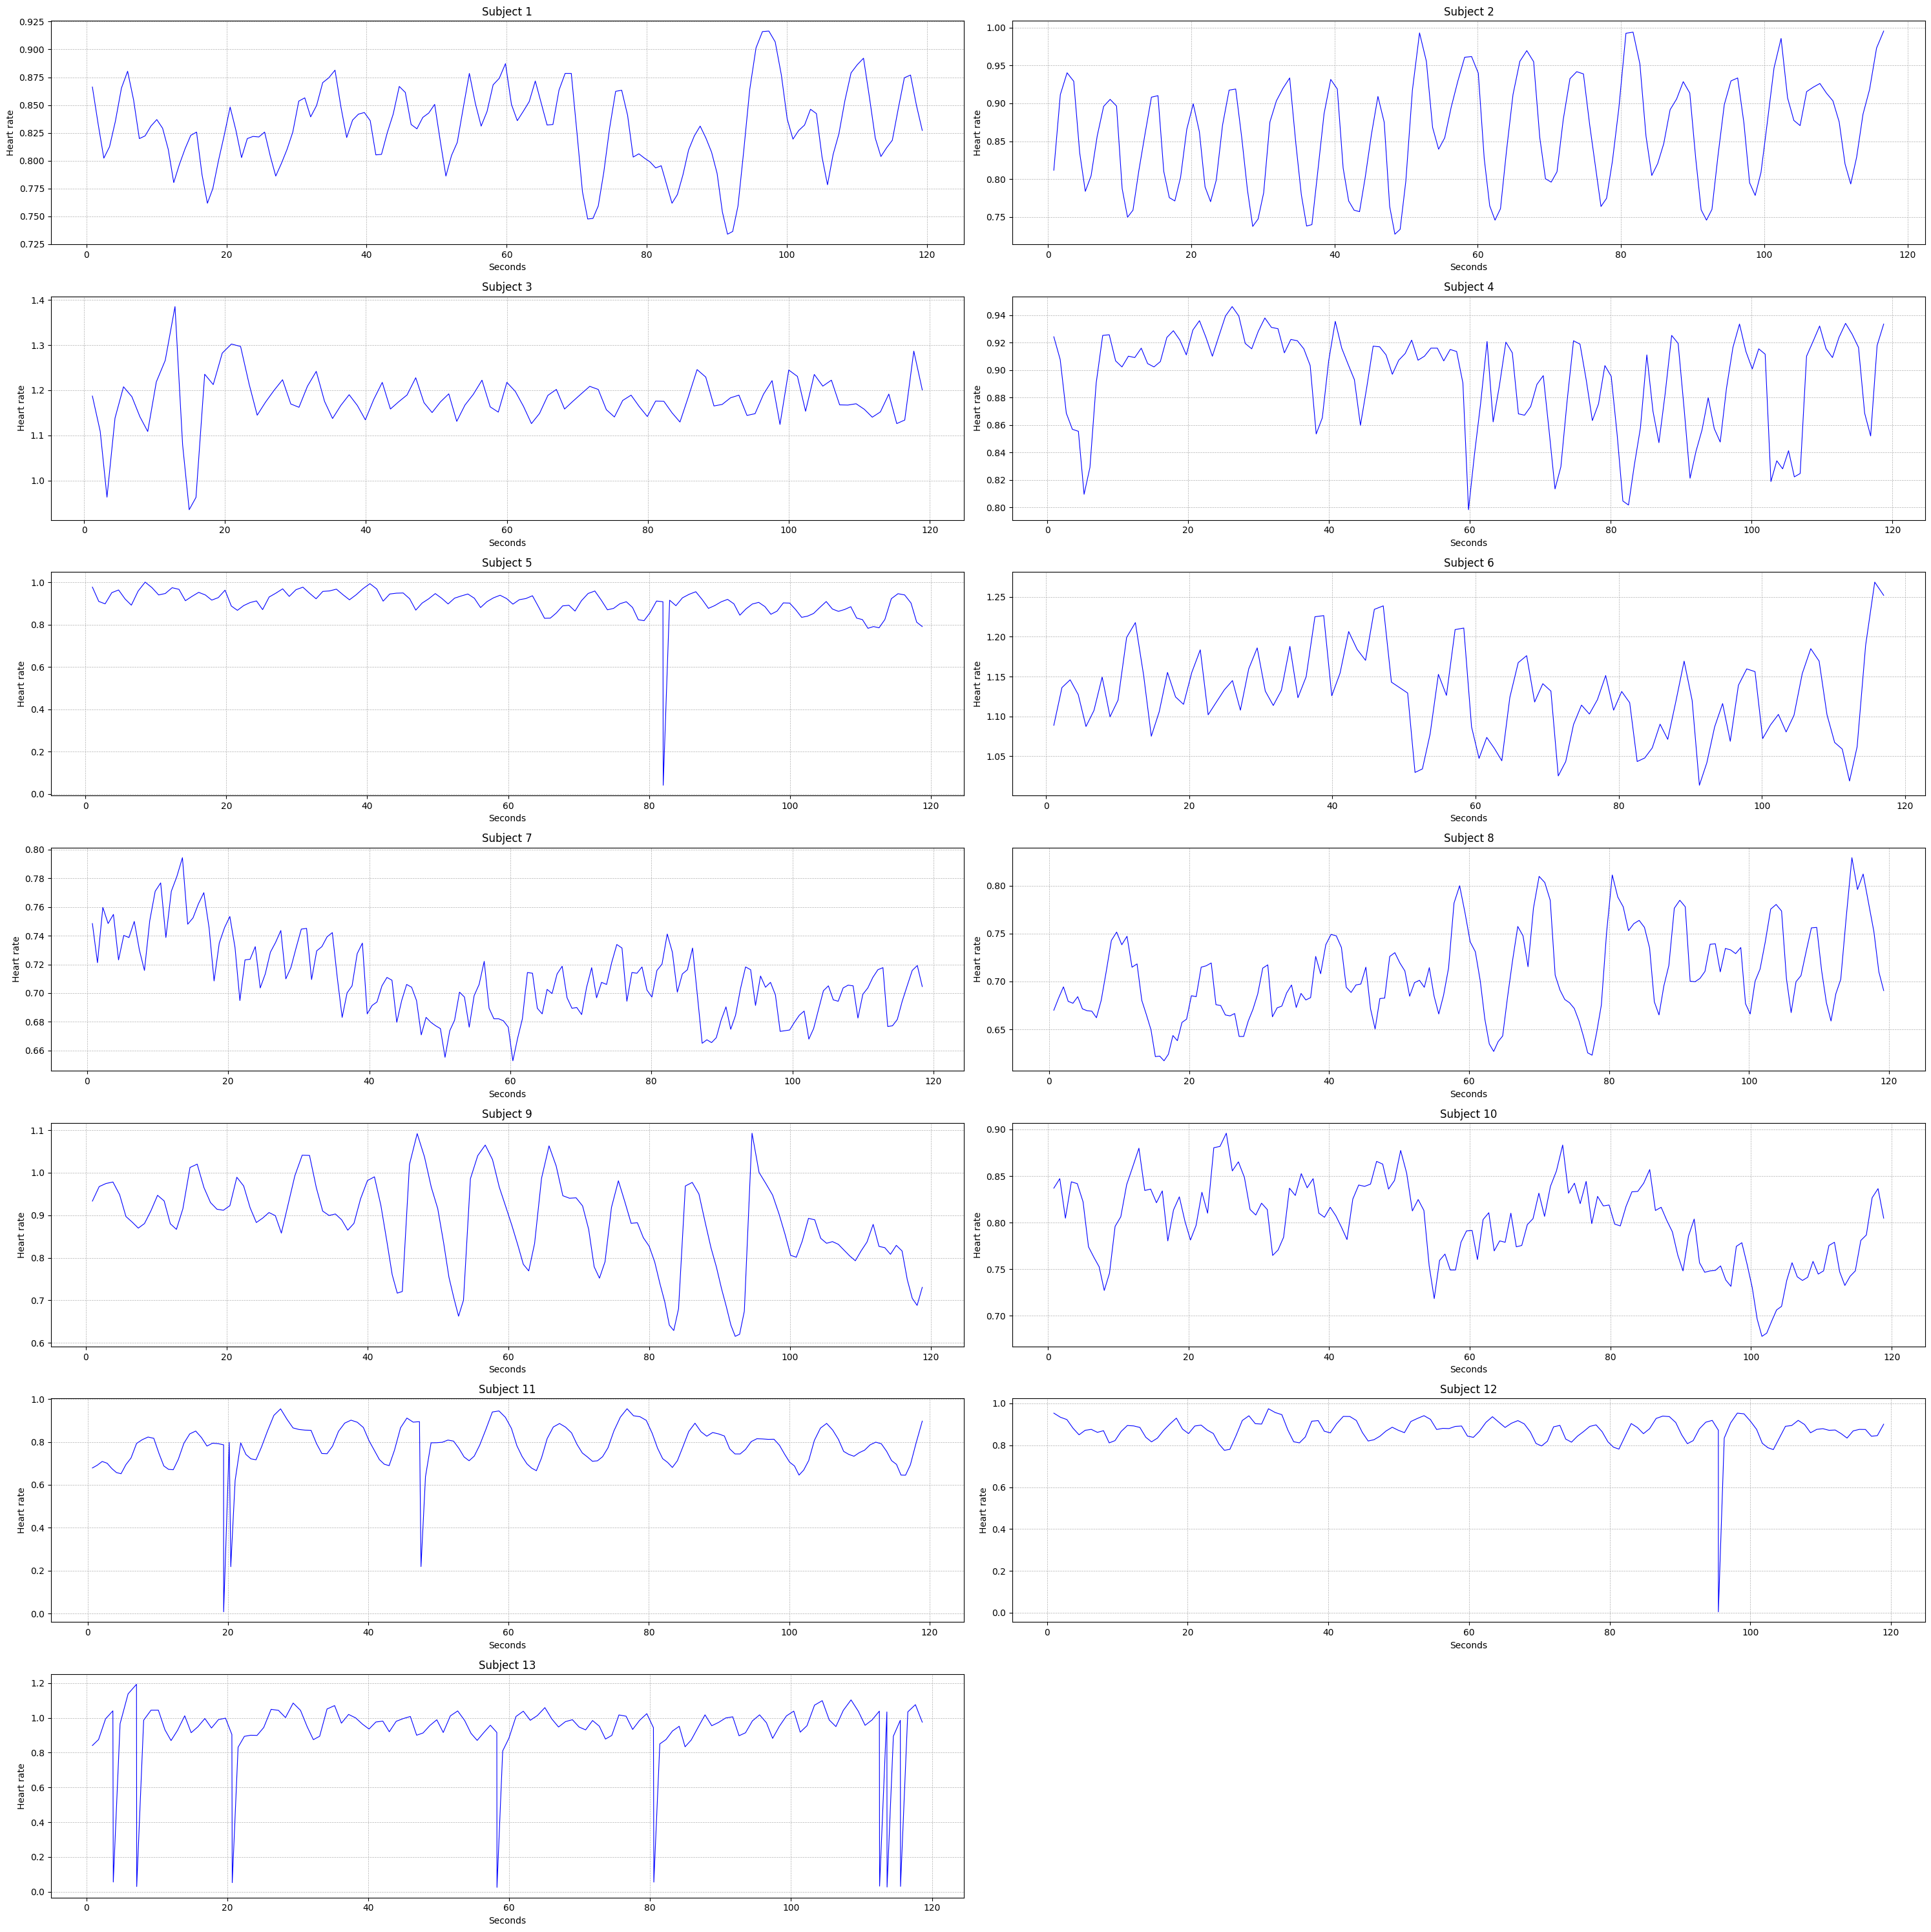

In [172]:
n_subjects = len(RR_Peaks_dict)
cols = 2  
rows = math.ceil(n_subjects / cols) 

plt.figure(figsize=(30, 30)) 

for i in range(1, n_subjects + 1):
    plt.subplot(rows, cols, i)   
     
    plt.plot(np.cumsum(RR_Peaks_dict[i][:-1])*0.001, RR_Peaks_dict[i][:-1]*0.001, color='blue', linewidth=0.8)
    plt.title(f'Subject {i}', fontsize=12)
    plt.xlabel('Seconds', fontsize=10)
    plt.ylabel('Heart rate', fontsize=10)
    plt.grid(True, linestyle='--', linewidth=0.5)
   
plt.tight_layout()
plt.show()

In [173]:
plot_invalid_RR_segments(ECG_data_preproccesed_dict, RR_Peaks_dict, invalid_intervals_dict, peaks_dict)

<Figure size 1500x0 with 0 Axes>

In [146]:
def interpolate_invalid_peaks(invalid_intervals_dict, peaks_dict):
    interpolated_peaks_dict = {}
    for subject in invalid_intervals_dict.keys():
        invalid_rrs = invalid_intervals_dict[subject]['mask']
        peak_interpolated_delete = np.delete(peaks_dict[subject], invalid_rrs)
        
        interpolated_peaks_dict[subject] = peak_interpolated_delete
    
    return interpolated_peaks_dict

In [155]:
peak_interpolated = interpolate_invalid_peaks(invalid_intervals_dict, peaks_dict)

In [156]:
def extract_rr_interpolated(peak_interpolated):
    interpolated_rr_intervals_dict = {}
    for key, peak_insert in peak_interpolated.items():
        interpolated_rr_intervals = hp.analysis.calc_rr(peak_insert, sample_rate=2048)
        interpolated_rr_intervals_dict[key] = interpolated_rr_intervals
    return interpolated_rr_intervals_dict

In [157]:
interpolated_rr_intervals_dict = extract_rr_interpolated(peak_interpolated)

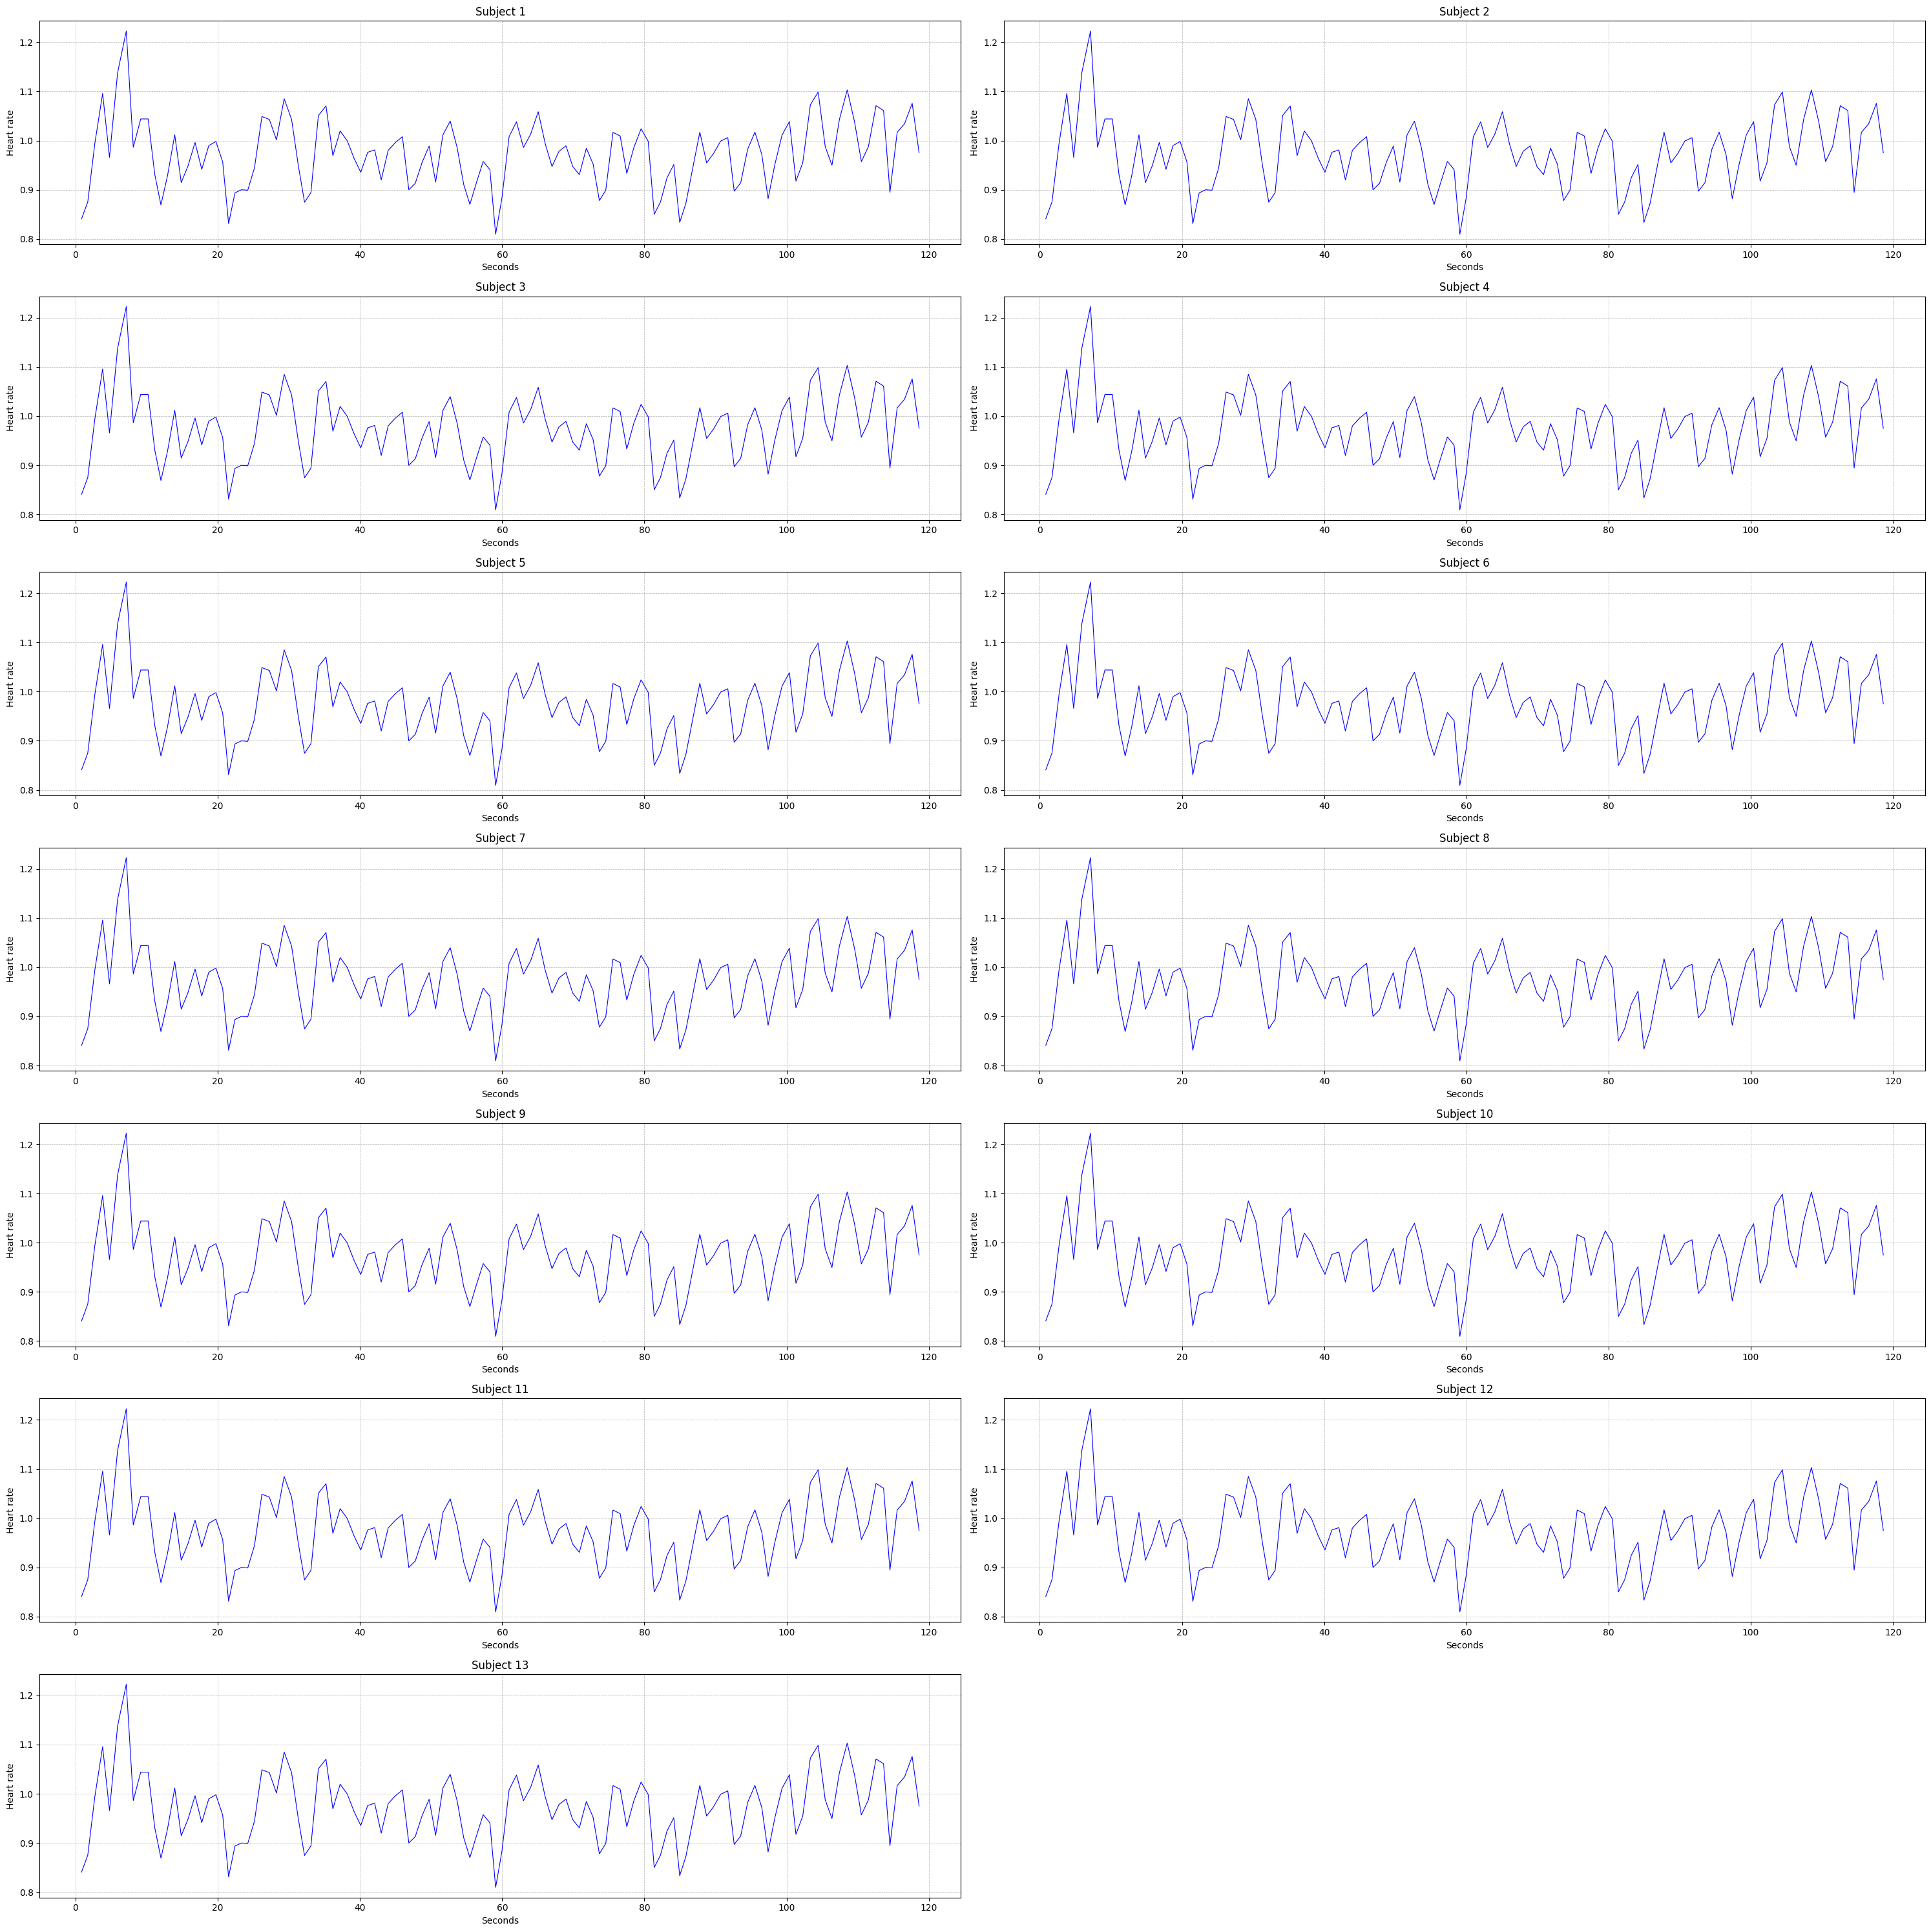

In [175]:
n_subjects = len(interpolated_rr_intervals_dict)
cols = 2
rows = math.ceil(n_subjects / cols) 

plt.figure(figsize=(30, 30)) 

for i in range(1, n_subjects + 1):
    plt.subplot(rows, cols, i)   
     
    plt.plot(np.cumsum(interpolated_rr_intervals_dict[i]['RR_list'])*0.001, interpolated_rr_intervals_dict[i]['RR_list']*0.001, color='blue', linewidth=0.8)
    plt.title(f'Subject {i}', fontsize=12)
    plt.xlabel('Seconds', fontsize=10)
    plt.ylabel('Heart rate', fontsize=10)
    plt.grid(True, linestyle='--', linewidth=0.5)
   
plt.tight_layout()
plt.show()

# Segmenting the RR intervals into 10 seconds windows

In [191]:
fs = 2048
total_samples = len(ECG_data_dict[1])
segment_duration_sec = 10
segment_length = segment_duration_sec * fs
num_segments = int(np.ceil(total_samples / segment_length))

segment_boundaries = [
    (int(i * segment_length), int(min((i + 1) * segment_length, total_samples)))
    for i in range(num_segments)
]

In [205]:
peaks_segments_dict =  {key: {} for key in ECG_data_dict.keys()}
for i, (start, end) in enumerate(segment_boundaries):
    for key, peaks in peak_interpolated.items():
        peaks_in_segment = peaks[(peaks >= start) & (peaks < end)]
        peaks_in_seconds = peaks_in_segment / fs
        peaks_segments_dict[key][i] = {'peaks': peaks_in_segment, 'times': peaks_in_seconds}

In [206]:
peaks_segments_dict

{1: {0: {'peaks': array([  887,  2661,  4366,  6009,  7673,  9384, 11156, 12959, 14709,
          16388, 18072, 19774]),
   'times': array([0.43310547, 1.29931641, 2.13183594, 2.93408203, 3.74658203,
          4.58203125, 5.44726562, 6.32763672, 7.18212891, 8.00195312,
          8.82421875, 9.65527344])},
  1: {'peaks': array([21488, 23186, 24845, 26443, 28074, 29734, 31419, 33110, 34722,
          36282, 37869, 39507]),
   'times': array([10.4921875 , 11.32128906, 12.13134766, 12.91162109, 13.70800781,
          14.51855469, 15.34130859, 16.16699219, 16.95410156, 17.71582031,
          18.49072266, 19.29052734])},
  2: {'peaks': array([41192, 42929, 44623, 46267, 47946, 49629, 51311, 53002, 54649,
          56259, 57892, 59551, 61242]),
   'times': array([20.11328125, 20.96142578, 21.78857422, 22.59130859, 23.41113281,
          24.23291016, 25.05419922, 25.87988281, 26.68408203, 27.47021484,
          28.26757812, 29.07763672, 29.90332031])},
  3: {'peaks': array([62990, 64744, 66463